# Project 3 - Autoencoder for Dimensionality Reduction

# Import libraries

In [1]:
import logging, os

import tensorflow as tf

import keras
from keras import layers

from tensorflow.keras.models import save_model, load_model

from sklearn.utils import shuffle
import numpy as np

import matplotlib.pyplot as plt

import optuna
from optuna.visualization import plot_pareto_front, plot_optimization_history, plot_slice

from math import ceil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load MNIST dataset

In [2]:
keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Split dataset into training and validation sets

In [3]:
def split_data(x, y, training_size):
    x, y = shuffle(x, y)
    x_train, y_train = x[0 : training_size], y[0 : training_size]
    x_val, y_val     = x[training_size : ],  y[training_size : ]
    return (x_train, y_train), (x_val, y_val)

# Normalize and flatten data

In [4]:
def normalize_data(x, factor):
    return x.astype('float32') / factor

def flatten_data(x):
    return np.reshape(x, (len(x), 784))

def tensor_data(x):
    return np.reshape(x, (len(x), 28, 28, 1))

In [5]:
TRAINING_SIZE = int(0.8 * x_train.shape[0])
(x_train, y_train), (x_val, y_val) = split_data(x_train, y_train, TRAINING_SIZE)

x_train = normalize_data(x_train, 255)
x_val   = normalize_data(x_val, 255)
x_test  = normalize_data(x_test, 255)

x_d_train = flatten_data(x_train)
x_d_val   = flatten_data(x_val)
x_d_test  = flatten_data(x_test)

x_c_train = tensor_data(x_train)
x_c_val   = tensor_data(x_val)
x_c_test  = tensor_data(x_test)

In [6]:
# print shapes
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(x_d_train.shape)
print(x_d_val.shape)
print(x_d_test.shape)

print(x_c_train.shape)
print(x_c_val.shape)
print(x_c_test.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)
(48000, 784)
(12000, 784)
(10000, 784)
(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


# Define Autoencoder model

In [ ]:
from autoencoder import Autoencoder
from helper_funcs import *

# Optimizing the Dense Autoencoder

To skip logs click [here](#Dense-Autoencoder-optimization-results).

In [11]:
def objective_dense(trial):
    dim_list = []
    layers = trial.suggest_int('num_layers', 2, 5)
    x_train, x_val, x_test = x_d_train, x_d_val, x_d_test
    for i in range(layers):
        if i == 0:
            dim_list.append(trial.suggest_int('dim_' + str(i), 50, 512))
        elif i == layers - 1:
            min_element = min(dim_list)
            if min_element > 50:
                dim_list.append(trial.suggest_int('dim_' + str(i), 10, 50))
        else:
            min_element = min(dim_list)
            dim_list.append(trial.suggest_int('dim_' + str(i), 10, min_element))
    
    print('Dim list:', dim_list)
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'gelu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    loss = 'binary_crossentropy'
    patience = trial.suggest_int('patience', 1, 10)
    autoencoder = Autoencoder('dense', dim_list, activation, optimizer, loss, patience)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    history = autoencoder.fit(x_train, x_train,
                              epochs=50,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_val, x_val),
                              callbacks=[autoencoder.es])
    save_model(autoencoder, 'model_' + 'dense_' + str(trial.number) + '.keras')
    np.save('history_' + 'dense_' + str(trial.number) + '.npy', history.history)
    encoded_imgs = autoencoder.encode(x_test)
    print('Shape of encoded vector:', encoded_imgs.shape)
    print('######################')
    return history.history['val_loss'][-1] # return validation loss of last epoch

In [12]:
study_dense = optuna.create_study(direction='minimize')
study_dense.optimize(objective_dense, n_trials=50, n_jobs=1)

[I 2023-12-24 10:46:54,584] A new study created in memory with name: no-name-9506ce9d-f4e2-493e-b7be-b6b3994e6de6


Dim list: [274, 234, 36, 26]
Epoch 1/50
94/94 [==============================] - 6s 10ms/step - loss: 0.6938 - val_loss: 0.6936
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 3/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.6927
Epoch 4/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6925 - val_loss: 0.6923
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6921 - val_loss: 0.6919
Epoch 6/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 7/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 8/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6908 - val_loss: 0.6906
Epoch 9/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6904 - val_loss: 0.6901
Epoch 10/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6899 - val_lo

[I 2023-12-24 10:47:40,952] Trial 0 finished with value: 0.573692798614502 and parameters: {'num_layers': 5, 'dim_0': 274, 'dim_1': 234, 'dim_2': 36, 'dim_3': 26, 'activation': 'elu', 'optimizer': 'adagrad', 'patience': 6, 'batch_size': 512}. Best is trial 0 with value: 0.573692798614502.


Shape of encoded vector: (10000, 26)
######################
Dim list: [213, 46]
Epoch 1/50
375/375 [==============================] - 5s 5ms/step - loss: 0.1856 - val_loss: 0.1286
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1184 - val_loss: 0.1100
Epoch 3/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1063 - val_loss: 0.1023
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1000 - val_loss: 0.0984
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.0957 - val_loss: 0.0938
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0929 - val_loss: 0.0916
Epoch 7/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0907 - val_loss: 0.0900
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 0.0891 - val_loss: 0.0884
Epoch 9/50
375/375 [==============================] - 1s 4ms/step - loss: 0.0877 - val_loss: 0.0871
Epoch 10/50
375/375 

[I 2023-12-24 10:49:00,591] Trial 1 finished with value: 0.07535693049430847 and parameters: {'num_layers': 2, 'dim_0': 213, 'dim_1': 46, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 46)
######################
Dim list: [472, 97, 22]
Epoch 1/50
94/94 [==============================] - 4s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 3/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 6/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 7/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 8/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 9/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 10/50
94/94 [==============

[I 2023-12-24 10:49:32,037] Trial 2 finished with value: 0.6894592046737671 and parameters: {'num_layers': 3, 'dim_0': 472, 'dim_1': 97, 'dim_2': 22, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 8, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 22)
######################
Dim list: [215, 59, 49]
Epoch 1/50
1500/1500 [==============================] - 8s 4ms/step - loss: 0.1784 - val_loss: 0.1400
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1310 - val_loss: 0.1238
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1181 - val_loss: 0.1134
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1106 - val_loss: 0.1083
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1064 - val_loss: 0.1047
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1031 - val_loss: 0.1017
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1004 - val_loss: 0.0993
Epoch 8/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0981 - val_loss: 0.0975
Epoch 9/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0962 - val_loss: 0.095

[I 2023-12-24 10:53:54,070] Trial 3 finished with value: 0.08057936280965805 and parameters: {'num_layers': 4, 'dim_0': 215, 'dim_1': 59, 'dim_2': 49, 'activation': 'elu', 'optimizer': 'adamax', 'patience': 6, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 49)
######################
Dim list: [473, 346, 13]
Epoch 1/50
94/94 [==============================] - 3s 9ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 2/50
94/94 [==============================] - 1s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 3/50
94/94 [==============================] - 1s 5ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
94/94 [==============================] - 1s 5ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 5/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/50
94/94 [==============================] - 1s 7ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 7/50
94/94 [==============================] - 1s 5ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 8/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 9/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 10/50
94/94 [==============

[I 2023-12-24 10:54:36,851] Trial 4 finished with value: 0.6911700963973999 and parameters: {'num_layers': 3, 'dim_0': 473, 'dim_1': 346, 'dim_2': 13, 'activation': 'relu', 'optimizer': 'adadelta', 'patience': 9, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 13)
######################
Dim list: [398, 137, 45]
Epoch 1/50
1500/1500 [==============================] - 12s 5ms/step - loss: 0.1433 - val_loss: 0.1123
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1039 - val_loss: 0.0985
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0951 - val_loss: 0.0927
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0911 - val_loss: 0.0900
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0884 - val_loss: 0.0873
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0862 - val_loss: 0.0860
Epoch 7/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0846 - val_loss: 0.0845
Epoch 8/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0833 - val_loss: 0.0836
Epoch 9/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0823 - val_loss: 0.0

[I 2023-12-24 11:00:29,508] Trial 5 finished with value: 0.07596750557422638 and parameters: {'num_layers': 4, 'dim_0': 398, 'dim_1': 137, 'dim_2': 45, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 45)
######################
Dim list: [267, 206, 64, 15]
Epoch 1/50
188/188 [==============================] - 5s 7ms/step - loss: 0.2642 - val_loss: 0.1952
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1716 - val_loss: 0.1578
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1532 - val_loss: 0.1496
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1453 - val_loss: 0.1417
Epoch 5/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1384 - val_loss: 0.1351
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1324 - val_loss: 0.1300
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1278 - val_loss: 0.1265
Epoch 8/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1246 - val_loss: 0.1235
Epoch 9/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1221 - val_loss: 0.1213
Epoch 10/50

[I 2023-12-24 11:01:23,538] Trial 6 finished with value: 0.10193413496017456 and parameters: {'num_layers': 4, 'dim_0': 267, 'dim_1': 206, 'dim_2': 64, 'dim_3': 15, 'activation': 'relu', 'optimizer': 'adam', 'patience': 6, 'batch_size': 256}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 15)
######################
Dim list: [292, 50]
Epoch 1/50
750/750 [==============================] - 6s 4ms/step - loss: 0.1480 - val_loss: 0.1109
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1030 - val_loss: 0.0973
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0941 - val_loss: 0.0914
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0896 - val_loss: 0.0885
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0867 - val_loss: 0.0857
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0847 - val_loss: 0.0842
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0833 - val_loss: 0.0832
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0821 - val_loss: 0.0820
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0811 - val_loss: 0.0810
Epoch 10/50
750/750 

[I 2023-12-24 11:02:41,594] Trial 7 finished with value: 0.07669833302497864 and parameters: {'num_layers': 3, 'dim_0': 292, 'dim_1': 50, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 1, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 50)
######################
Dim list: [184, 11]
Epoch 1/50
94/94 [==============================] - 3s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 5/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 7/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 10/50
94/94 [===================

[I 2023-12-24 11:03:09,890] Trial 8 finished with value: 0.6920068264007568 and parameters: {'num_layers': 2, 'dim_0': 184, 'dim_1': 11, 'activation': 'gelu', 'optimizer': 'adadelta', 'patience': 10, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 11)
######################
Dim list: [319, 307, 13]
Epoch 1/50
94/94 [==============================] - 3s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
94/94 [==============================] - 1s 12ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 5/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 6/50
94/94 [==============================] - 1s 5ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 7/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 8/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 9/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6923 - val_loss: 0.6923
Epoch 10/50
94/94 [=============

[I 2023-12-24 11:03:38,721] Trial 9 finished with value: 0.6878079175949097 and parameters: {'num_layers': 3, 'dim_0': 319, 'dim_1': 307, 'dim_2': 13, 'activation': 'relu', 'optimizer': 'adagrad', 'patience': 3, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 13)
######################
Dim list: [51, 28]
Epoch 1/50
375/375 [==============================] - 5s 5ms/step - loss: 0.2473 - val_loss: 0.1801
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1641 - val_loss: 0.1518
Epoch 3/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1447 - val_loss: 0.1385
Epoch 4/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1353 - val_loss: 0.1316
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1291 - val_loss: 0.1263
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1249 - val_loss: 0.1238
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1216 - val_loss: 0.1204
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1192 - val_loss: 0.1181
Epoch 9/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1175 - val_loss: 0.1167
Epoch 10/50
375/375 [

[I 2023-12-24 11:04:56,821] Trial 10 finished with value: 0.09590490907430649 and parameters: {'num_layers': 2, 'dim_0': 51, 'dim_1': 28, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 4, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 28)
######################
Dim list: [361, 131, 110, 110, 23]
Epoch 1/50
1500/1500 [==============================] - 16s 7ms/step - loss: 0.1691 - val_loss: 0.1371
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1304 - val_loss: 0.1237
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1203 - val_loss: 0.1167
Epoch 4/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1140 - val_loss: 0.1125
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1103 - val_loss: 0.1097
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1079 - val_loss: 0.1081
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1062 - val_loss: 0.1068
Epoch 8/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1048 - val_loss: 0.1059
Epoch 9/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1037 - v

[I 2023-12-24 11:12:25,597] Trial 11 finished with value: 0.09727533906698227 and parameters: {'num_layers': 5, 'dim_0': 361, 'dim_1': 131, 'dim_2': 110, 'dim_3': 110, 'dim_4': 23, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 1, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 23)
######################
Dim list: [403, 157, 149, 44]
Epoch 1/50
375/375 [==============================] - 8s 8ms/step - loss: 0.1941 - val_loss: 0.1441
Epoch 2/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1340 - val_loss: 0.1248
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1203 - val_loss: 0.1141
Epoch 4/50
375/375 [==============================] - 2s 7ms/step - loss: 0.1114 - val_loss: 0.1082
Epoch 5/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1060 - val_loss: 0.1035
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1020 - val_loss: 0.1000
Epoch 7/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0989 - val_loss: 0.0976
Epoch 8/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0963 - val_loss: 0.0955
Epoch 9/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0942 - val_loss: 0.0944
Epoch 10/5

[I 2023-12-24 11:14:50,630] Trial 12 finished with value: 0.08034391701221466 and parameters: {'num_layers': 4, 'dim_0': 403, 'dim_1': 157, 'dim_2': 149, 'dim_3': 44, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 3, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 44)
######################
Dim list: [131, 10]
Epoch 1/50
375/375 [==============================] - 5s 5ms/step - loss: 0.2420 - val_loss: 0.1878
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1812 - val_loss: 0.1740
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1706 - val_loss: 0.1670
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1642 - val_loss: 0.1585
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1560 - val_loss: 0.1531
Epoch 6/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1517 - val_loss: 0.1498
Epoch 7/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1488 - val_loss: 0.1473
Epoch 8/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1465 - val_loss: 0.1456
Epoch 9/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1449 - val_loss: 0.1440
Epoch 10/50
375/375 

[I 2023-12-24 11:16:14,418] Trial 13 finished with value: 0.12684451043605804 and parameters: {'num_layers': 2, 'dim_0': 131, 'dim_1': 10, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 10)
######################
Dim list: [405, 196, 89, 43]
Epoch 1/50
1500/1500 [==============================] - 9s 4ms/step - loss: 0.1849 - val_loss: 0.1380
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1262 - val_loss: 0.1170
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1122 - val_loss: 0.1075
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1050 - val_loss: 0.1025
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0999 - val_loss: 0.0983
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0964 - val_loss: 0.0954
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0938 - val_loss: 0.0931
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0917 - val_loss: 0.0914
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0900 - val_loss: 

[I 2023-12-24 11:21:15,462] Trial 14 finished with value: 0.07774555683135986 and parameters: {'num_layers': 4, 'dim_0': 405, 'dim_1': 196, 'dim_2': 89, 'dim_3': 43, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 4, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 43)
######################
Dim list: [510, 442, 349, 334, 50]
Epoch 1/50
188/188 [==============================] - 6s 8ms/step - loss: 0.2558 - val_loss: 0.2077
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1741 - val_loss: 0.1513
Epoch 3/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1454 - val_loss: 0.1396
Epoch 4/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1339 - val_loss: 0.1288
Epoch 5/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1247 - val_loss: 0.1223
Epoch 6/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1190 - val_loss: 0.1178
Epoch 7/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1151 - val_loss: 0.1145
Epoch 8/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1120 - val_loss: 0.1120
Epoch 9/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1101 - val_loss: 0.1099
Epoch

[I 2023-12-24 11:22:15,656] Trial 15 finished with value: 0.08739026635885239 and parameters: {'num_layers': 5, 'dim_0': 510, 'dim_1': 442, 'dim_2': 349, 'dim_3': 334, 'dim_4': 50, 'activation': 'relu', 'optimizer': 'adam', 'patience': 4, 'batch_size': 256}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 50)
######################
Dim list: [201, 18]
Epoch 1/50
750/750 [==============================] - 7s 5ms/step - loss: 0.1896 - val_loss: 0.1510
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1414 - val_loss: 0.1338
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1300 - val_loss: 0.1266
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1244 - val_loss: 0.1220
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1206 - val_loss: 0.1190
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1177 - val_loss: 0.1165
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1154 - val_loss: 0.1145
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1133 - val_loss: 0.1130
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1117 - val_loss: 0.1113
Epoch 10/50
750/750 

[I 2023-12-24 11:24:55,337] Trial 16 finished with value: 0.09548354893922806 and parameters: {'num_layers': 2, 'dim_0': 201, 'dim_1': 18, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 18)
######################
Dim list: [143, 75, 34]
Epoch 1/50
1500/1500 [==============================] - 10s 4ms/step - loss: 0.1609 - val_loss: 0.1238
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1167 - val_loss: 0.1099
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1065 - val_loss: 0.1038
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1017 - val_loss: 0.0999
Epoch 5/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0984 - val_loss: 0.0974
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0961 - val_loss: 0.0957
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0945 - val_loss: 0.0942
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0930 - val_loss: 0.0926
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0918 - val_loss: 0.09

[I 2023-12-24 11:30:26,581] Trial 17 finished with value: 0.08311126381158829 and parameters: {'num_layers': 3, 'dim_0': 143, 'dim_1': 75, 'dim_2': 34, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 34)
######################
Dim list: [348, 109, 63, 11]
Epoch 1/50
375/375 [==============================] - 8s 7ms/step - loss: 0.2266 - val_loss: 0.1851
Epoch 2/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1707 - val_loss: 0.1540
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1487 - val_loss: 0.1433
Epoch 4/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1408 - val_loss: 0.1384
Epoch 5/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1362 - val_loss: 0.1334
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1315 - val_loss: 0.1296
Epoch 7/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1280 - val_loss: 0.1270
Epoch 8/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1254 - val_loss: 0.1250
Epoch 9/50
375/375 [==============================] - 2s 6ms/step - loss: 0.1233 - val_loss: 0.1229
Epoch 10/50

[I 2023-12-24 11:32:27,784] Trial 18 finished with value: 0.10782796144485474 and parameters: {'num_layers': 4, 'dim_0': 348, 'dim_1': 109, 'dim_2': 63, 'dim_3': 11, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 7, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 11)
######################
Dim list: [397, 139, 94, 74, 10]
Epoch 1/50
1500/1500 [==============================] - 10s 5ms/step - loss: 0.2000 - val_loss: 0.1627
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1560 - val_loss: 0.1476
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1433 - val_loss: 0.1394
Epoch 4/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1369 - val_loss: 0.1347
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1331 - val_loss: 0.1313
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1305 - val_loss: 0.1297
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1285 - val_loss: 0.1282
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1268 - val_loss: 0.1264
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1255 - val_l

[I 2023-12-24 11:38:01,089] Trial 19 finished with value: 0.11588194966316223 and parameters: {'num_layers': 5, 'dim_0': 397, 'dim_1': 139, 'dim_2': 94, 'dim_3': 74, 'dim_4': 10, 'activation': 'elu', 'optimizer': 'adamax', 'patience': 5, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 10)
######################
Dim list: [240, 25]
Epoch 1/50
375/375 [==============================] - 4s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 2: early stopping


[I 2023-12-24 11:38:07,017] Trial 20 finished with value: 0.692836344242096 and parameters: {'num_layers': 2, 'dim_0': 240, 'dim_1': 25, 'activation': 'gelu', 'optimizer': 'adadelta', 'patience': 1, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 25)
######################
Dim list: [304, 64, 28]
Epoch 1/50
750/750 [==============================] - 8s 6ms/step - loss: 0.1648 - val_loss: 0.1268
Epoch 2/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1179 - val_loss: 0.1116
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1081 - val_loss: 0.1051
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1026 - val_loss: 0.1010
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0990 - val_loss: 0.0976
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0963 - val_loss: 0.0957
Epoch 7/50
750/750 [==============================] - 3s 5ms/step - loss: 0.0943 - val_loss: 0.0937
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0926 - val_loss: 0.0924
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0913 - val_loss: 0.0916
Epoch 10/50
750/

[I 2023-12-24 11:40:38,692] Trial 21 finished with value: 0.08415389060974121 and parameters: {'num_layers': 3, 'dim_0': 304, 'dim_1': 64, 'dim_2': 28, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 1, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 28)
######################
Dim list: [149, 43]
Epoch 1/50
750/750 [==============================] - 6s 4ms/step - loss: 0.1660 - val_loss: 0.1232
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1143 - val_loss: 0.1079
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1047 - val_loss: 0.1020
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0999 - val_loss: 0.0978
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0962 - val_loss: 0.0946
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0935 - val_loss: 0.0924
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0914 - val_loss: 0.0906
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0898 - val_loss: 0.0894
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0886 - val_loss: 0.0883
Epoch 10/50
750/750 

[I 2023-12-24 11:44:02,586] Trial 22 finished with value: 0.07747318595647812 and parameters: {'num_layers': 3, 'dim_0': 149, 'dim_1': 43, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 3, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 43)
######################
Dim list: [73, 39, 21]
Epoch 1/50
750/750 [==============================] - 8s 5ms/step - loss: 0.2137 - val_loss: 0.1640
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1566 - val_loss: 0.1495
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1466 - val_loss: 0.1424
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1402 - val_loss: 0.1378
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1363 - val_loss: 0.1344
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1328 - val_loss: 0.1312
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1293 - val_loss: 0.1271
Epoch 8/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1260 - val_loss: 0.1247
Epoch 9/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1234 - val_loss: 0.1223
Epoch 10/50
750/7

[I 2023-12-24 11:46:57,865] Trial 23 finished with value: 0.10135587304830551 and parameters: {'num_layers': 4, 'dim_0': 73, 'dim_1': 39, 'dim_2': 21, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 21)
######################
Dim list: [251, 34]
Epoch 1/50
750/750 [==============================] - 6s 4ms/step - loss: 0.1628 - val_loss: 0.1267
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1193 - val_loss: 0.1122
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1081 - val_loss: 0.1050
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1030 - val_loss: 0.1008
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0989 - val_loss: 0.0974
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0957 - val_loss: 0.0945
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0933 - val_loss: 0.0924
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0913 - val_loss: 0.0909
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0898 - val_loss: 0.0895
Epoch 10/50
750/750 

[I 2023-12-24 11:48:30,898] Trial 24 finished with value: 0.08129391074180603 and parameters: {'num_layers': 2, 'dim_0': 251, 'dim_1': 34, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 1, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 34)
######################
Dim list: [320, 95, 38]
Epoch 1/50
188/188 [==============================] - 4s 6ms/step - loss: 0.2195 - val_loss: 0.1551
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1406 - val_loss: 0.1304
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1249 - val_loss: 0.1189
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1147 - val_loss: 0.1114
Epoch 5/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1085 - val_loss: 0.1061
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1040 - val_loss: 0.1024
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1002 - val_loss: 0.0995
Epoch 8/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0975 - val_loss: 0.0966
Epoch 9/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0956 - val_loss: 0.0951
Epoch 10/50
188/

[I 2023-12-24 11:49:21,108] Trial 25 finished with value: 0.08022657781839371 and parameters: {'num_layers': 3, 'dim_0': 320, 'dim_1': 95, 'dim_2': 38, 'activation': 'elu', 'optimizer': 'adam', 'patience': 3, 'batch_size': 256}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 38)
######################
Dim list: [365, 176, 145, 23]
Epoch 1/50
750/750 [==============================] - 9s 6ms/step - loss: 0.1817 - val_loss: 0.1427
Epoch 2/50
750/750 [==============================] - 4s 6ms/step - loss: 0.1313 - val_loss: 0.1224
Epoch 3/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1178 - val_loss: 0.1126
Epoch 4/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1105 - val_loss: 0.1087
Epoch 5/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1062 - val_loss: 0.1043
Epoch 6/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1023 - val_loss: 0.1011
Epoch 7/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0996 - val_loss: 0.0990
Epoch 8/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0977 - val_loss: 0.0974
Epoch 9/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0963 - val_loss: 0.0977
Epoch 10/5

[I 2023-12-24 11:52:45,947] Trial 26 finished with value: 0.08731697499752045 and parameters: {'num_layers': 4, 'dim_0': 365, 'dim_1': 176, 'dim_2': 145, 'dim_3': 23, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 23)
######################
Dim list: [457, 248, 41]
Epoch 1/50
1500/1500 [==============================] - 11s 5ms/step - loss: 0.1345 - val_loss: 0.1047
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0982 - val_loss: 0.0934
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0909 - val_loss: 0.0892
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0875 - val_loss: 0.0872
Epoch 5/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0854 - val_loss: 0.0856
Epoch 6/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0840 - val_loss: 0.0846
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0830 - val_loss: 0.0833
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0822 - val_loss: 0.0832
Epoch 9/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0816 - val_loss: 0.0

[I 2023-12-24 11:58:22,920] Trial 27 finished with value: 0.07864252477884293 and parameters: {'num_layers': 3, 'dim_0': 457, 'dim_1': 248, 'dim_2': 41, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 5, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 41)
######################
Dim list: [434, 20]
Epoch 1/50
375/375 [==============================] - 5s 5ms/step - loss: 0.1856 - val_loss: 0.1464
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1353 - val_loss: 0.1268
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1224 - val_loss: 0.1184
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1160 - val_loss: 0.1138
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1123 - val_loss: 0.1108
Epoch 6/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1097 - val_loss: 0.1088
Epoch 7/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1077 - val_loss: 0.1073
Epoch 8/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1062 - val_loss: 0.1060
Epoch 9/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1049 - val_loss: 0.1048
Epoch 10/50
375/375 

[I 2023-12-24 11:59:46,322] Trial 28 finished with value: 0.09569989144802094 and parameters: {'num_layers': 2, 'dim_0': 434, 'dim_1': 20, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 1, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 20)
######################
Dim list: [279, 82, 51, 36]
Epoch 1/50
375/375 [==============================] - 5s 6ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 3/50
375/375 [==============================] - 2s 5ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.6922 - val_loss: 0.6920
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.6919 - val_loss: 0.6917
Epoch 6/50
375/375 [==============================] - 2s 4ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 0.6913 - val_loss: 0.6912
Epoch 8/50
375/375 [==============================] - 2s 4ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 9/50
375/375 [==============================] - 2s 4ms/step - loss: 0.6908 - val_loss: 0.6906
Epoch 10/50


[I 2023-12-24 12:01:16,220] Trial 29 finished with value: 0.6793760061264038 and parameters: {'num_layers': 5, 'dim_0': 279, 'dim_1': 82, 'dim_2': 51, 'dim_3': 36, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 4, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 36)
######################
Dim list: [173, 56, 27]
Epoch 1/50
750/750 [==============================] - 6s 4ms/step - loss: 0.1770 - val_loss: 0.1365
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1288 - val_loss: 0.1235
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1192 - val_loss: 0.1156
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1134 - val_loss: 0.1117
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1098 - val_loss: 0.1084
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1069 - val_loss: 0.1058
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1044 - val_loss: 0.1036
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1026 - val_loss: 0.1024
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1012 - val_loss: 0.1010
Epoch 10/50
750/

[I 2023-12-24 12:03:40,267] Trial 30 finished with value: 0.09187157452106476 and parameters: {'num_layers': 3, 'dim_0': 173, 'dim_1': 56, 'dim_2': 27, 'activation': 'elu', 'optimizer': 'adam', 'patience': 3, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 27)
######################
Dim list: [107, 47]
Epoch 1/50
750/750 [==============================] - 7s 5ms/step - loss: 0.1724 - val_loss: 0.1290
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1198 - val_loss: 0.1121
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1088 - val_loss: 0.1054
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1028 - val_loss: 0.1006
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0988 - val_loss: 0.0972
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0960 - val_loss: 0.0948
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0939 - val_loss: 0.0931
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0922 - val_loss: 0.0915
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0907 - val_loss: 0.0903
Epoch 10/50
750/750 

[I 2023-12-24 12:07:04,985] Trial 31 finished with value: 0.07875433564186096 and parameters: {'num_layers': 3, 'dim_0': 107, 'dim_1': 47, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 47)
######################
Dim list: [232, 111, 10]
Epoch 1/50
750/750 [==============================] - 8s 5ms/step - loss: 0.1985 - val_loss: 0.1581
Epoch 2/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1505 - val_loss: 0.1446
Epoch 3/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1420 - val_loss: 0.1396
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1359 - val_loss: 0.1319
Epoch 5/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1298 - val_loss: 0.1281
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1266 - val_loss: 0.1260
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1244 - val_loss: 0.1238
Epoch 8/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1226 - val_loss: 0.1225
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1209 - val_loss: 0.1202
Epoch 10/50
750

[I 2023-12-24 12:10:00,737] Trial 32 finished with value: 0.10802619159221649 and parameters: {'num_layers': 3, 'dim_0': 232, 'dim_1': 111, 'dim_2': 10, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 3, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 10)
######################
Dim list: [146, 50, 22]
Epoch 1/50
750/750 [==============================] - 5s 4ms/step - loss: 0.6931 - val_loss: 0.6920
Epoch 2/50
750/750 [==============================] - 3s 3ms/step - loss: 0.6908 - val_loss: 0.6893
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.6876 - val_loss: 0.6855
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.6826 - val_loss: 0.6792
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.6745 - val_loss: 0.6689
Epoch 6/50
750/750 [==============================] - 3s 3ms/step - loss: 0.6609 - val_loss: 0.6514
Epoch 7/50
750/750 [==============================] - 3s 3ms/step - loss: 0.6379 - val_loss: 0.6214
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.5974 - val_loss: 0.5683
Epoch 9/50
750/750 [==============================] - 3s 3ms/step - loss: 0.5277 - val_loss: 0.4808
Epoch 10/50
750/

[I 2023-12-24 12:12:18,141] Trial 33 finished with value: 0.26099348068237305 and parameters: {'num_layers': 4, 'dim_0': 146, 'dim_1': 50, 'dim_2': 22, 'activation': 'elu', 'optimizer': 'adagrad', 'patience': 1, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 22)
######################
Dim list: [216, 72, 42]
Epoch 1/50
1500/1500 [==============================] - 8s 4ms/step - loss: 0.1702 - val_loss: 0.1333
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1249 - val_loss: 0.1172
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1123 - val_loss: 0.1085
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1056 - val_loss: 0.1036
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1015 - val_loss: 0.0994
Epoch 6/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0980 - val_loss: 0.0969
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0956 - val_loss: 0.0951
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0940 - val_loss: 0.0933
Epoch 9/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0926 - val_loss: 0.092

[I 2023-12-24 12:17:41,866] Trial 34 finished with value: 0.0784471333026886 and parameters: {'num_layers': 3, 'dim_0': 216, 'dim_1': 72, 'dim_2': 42, 'activation': 'elu', 'optimizer': 'adamax', 'patience': 2, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 42)
######################
Dim list: [162, 43, 18]
Epoch 1/50
750/750 [==============================] - 8s 5ms/step - loss: 0.1943 - val_loss: 0.1548
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1465 - val_loss: 0.1387
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1342 - val_loss: 0.1297
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1270 - val_loss: 0.1247
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1232 - val_loss: 0.1223
Epoch 6/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1207 - val_loss: 0.1200
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1188 - val_loss: 0.1183
Epoch 8/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1172 - val_loss: 0.1169
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1160 - val_loss: 0.1161
Epoch 10/50
750/

[I 2023-12-24 12:20:36,013] Trial 35 finished with value: 0.09974700957536697 and parameters: {'num_layers': 4, 'dim_0': 162, 'dim_1': 43, 'dim_2': 18, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 3, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 18)
######################
Dim list: [106, 35]
Epoch 1/50
94/94 [==============================] - 3s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 7/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 10/50
94/94 [===================

[I 2023-12-24 12:21:04,418] Trial 36 finished with value: 0.6920440196990967 and parameters: {'num_layers': 2, 'dim_0': 106, 'dim_1': 35, 'activation': 'gelu', 'optimizer': 'adadelta', 'patience': 5, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 35)
######################
Dim list: [295, 94, 31]
Epoch 1/50
188/188 [==============================] - 5s 7ms/step - loss: 0.2318 - val_loss: 0.1639
Epoch 2/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1503 - val_loss: 0.1388
Epoch 3/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1337 - val_loss: 0.1316
Epoch 4/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1237 - val_loss: 0.1205
Epoch 5/50
188/188 [==============================] - 1s 7ms/step - loss: 0.1167 - val_loss: 0.1143
Epoch 6/50
188/188 [==============================] - 1s 7ms/step - loss: 0.1118 - val_loss: 0.1095
Epoch 7/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1080 - val_loss: 0.1095
Epoch 8/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1052 - val_loss: 0.1051
Epoch 9/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1032 - val_loss: 0.1039
Epoch 10/50
188/

[I 2023-12-24 12:22:03,617] Trial 37 finished with value: 0.08468665927648544 and parameters: {'num_layers': 3, 'dim_0': 295, 'dim_1': 94, 'dim_2': 31, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 7, 'batch_size': 256}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 31)
######################
Dim list: [200, 138, 80, 19]
Epoch 1/50
1500/1500 [==============================] - 8s 4ms/step - loss: 0.6906 - val_loss: 0.6859
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6737 - val_loss: 0.6534
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5955 - val_loss: 0.5031
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3799 - val_loss: 0.2976
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2827 - val_loss: 0.2745
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2726 - val_loss: 0.2699
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2696 - val_loss: 0.2679
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2680 - val_loss: 0.2666
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2669 - val_loss: 

[I 2023-12-24 12:26:49,243] Trial 38 finished with value: 0.24885064363479614 and parameters: {'num_layers': 4, 'dim_0': 200, 'dim_1': 138, 'dim_2': 80, 'dim_3': 19, 'activation': 'elu', 'optimizer': 'adagrad', 'patience': 1, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 19)
######################
Dim list: [273, 66, 33]
Epoch 1/50
94/94 [==============================] - 3s 9ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3: early stopping


[I 2023-12-24 12:26:54,441] Trial 39 finished with value: 0.6929395198822021 and parameters: {'num_layers': 3, 'dim_0': 273, 'dim_1': 66, 'dim_2': 33, 'activation': 'relu', 'optimizer': 'adadelta', 'patience': 2, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 33)
######################
Dim list: [334, 37]
Epoch 1/50
750/750 [==============================] - 7s 5ms/step - loss: 0.1621 - val_loss: 0.1221
Epoch 2/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1120 - val_loss: 0.1040
Epoch 3/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1010 - val_loss: 0.0984
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0966 - val_loss: 0.0952
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0939 - val_loss: 0.0930
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0920 - val_loss: 0.0917
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0906 - val_loss: 0.0903
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0894 - val_loss: 0.0895
Epoch 9/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0883 - val_loss: 0.0883
Epoch 10/50
750/750 

[I 2023-12-24 12:29:38,261] Trial 40 finished with value: 0.07813330739736557 and parameters: {'num_layers': 2, 'dim_0': 334, 'dim_1': 37, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 10, 'batch_size': 64}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 37)
######################
Dim list: [408, 220, 147, 38]
Epoch 1/50
1500/1500 [==============================] - 9s 4ms/step - loss: 0.1857 - val_loss: 0.1381
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1268 - val_loss: 0.1188
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1134 - val_loss: 0.1084
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1054 - val_loss: 0.1029
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1004 - val_loss: 0.0988
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0965 - val_loss: 0.0951
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0936 - val_loss: 0.0929
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0915 - val_loss: 0.0915
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0899 - val_loss:

[I 2023-12-24 12:34:44,628] Trial 41 finished with value: 0.0787423625588417 and parameters: {'num_layers': 4, 'dim_0': 408, 'dim_1': 220, 'dim_2': 147, 'dim_3': 38, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 4, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 38)
######################
Dim list: [384, 188, 123, 44]
Epoch 1/50
1500/1500 [==============================] - 9s 4ms/step - loss: 0.1877 - val_loss: 0.1401
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1281 - val_loss: 0.1191
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1130 - val_loss: 0.1083
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1054 - val_loss: 0.1025
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1002 - val_loss: 0.0985
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0965 - val_loss: 0.0954
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0938 - val_loss: 0.0933
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0917 - val_loss: 0.0914
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0901 - val_loss:

[I 2023-12-24 12:40:08,578] Trial 42 finished with value: 0.07846995443105698 and parameters: {'num_layers': 4, 'dim_0': 384, 'dim_1': 188, 'dim_2': 123, 'dim_3': 44, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 4, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 44)
######################
Dim list: [507, 293, 207, 33]
Epoch 1/50
1500/1500 [==============================] - 10s 5ms/step - loss: 0.1758 - val_loss: 0.1348
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1244 - val_loss: 0.1168
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1112 - val_loss: 0.1065
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1034 - val_loss: 0.1012
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0985 - val_loss: 0.0976
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0950 - val_loss: 0.0942
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0925 - val_loss: 0.0921
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0906 - val_loss: 0.0907
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0890 - val_loss

[I 2023-12-24 12:45:32,522] Trial 43 finished with value: 0.07997363060712814 and parameters: {'num_layers': 4, 'dim_0': 507, 'dim_1': 293, 'dim_2': 207, 'dim_3': 33, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 3, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 33)
######################
Dim list: [429, 175, 81, 44]
Epoch 1/50
1500/1500 [==============================] - 9s 4ms/step - loss: 0.1856 - val_loss: 0.1380
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1269 - val_loss: 0.1182
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1132 - val_loss: 0.1089
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1058 - val_loss: 0.1030
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1010 - val_loss: 0.0997
Epoch 6/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0978 - val_loss: 0.0971
Epoch 7/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0952 - val_loss: 0.0948
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0931 - val_loss: 0.0927
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0913 - val_loss: 

[I 2023-12-24 12:50:35,946] Trial 44 finished with value: 0.07959931343793869 and parameters: {'num_layers': 4, 'dim_0': 429, 'dim_1': 175, 'dim_2': 81, 'dim_3': 44, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 4, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 44)
######################
Dim list: [457, 251, 24]
Epoch 1/50
375/375 [==============================] - 4s 5ms/step - loss: 0.2286 - val_loss: 0.1667
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1492 - val_loss: 0.1376
Epoch 3/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1325 - val_loss: 0.1273
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1235 - val_loss: 0.1198
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1170 - val_loss: 0.1145
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1130 - val_loss: 0.1115
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1099 - val_loss: 0.1086
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1074 - val_loss: 0.1065
Epoch 9/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1051 - val_loss: 0.1043
Epoch 10/50
375

[I 2023-12-24 12:51:52,993] Trial 45 finished with value: 0.08787928521633148 and parameters: {'num_layers': 3, 'dim_0': 457, 'dim_1': 251, 'dim_2': 24, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 3, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 24)
######################
Dim list: [376, 120, 55, 50]
Epoch 1/50
1500/1500 [==============================] - 14s 6ms/step - loss: 0.1539 - val_loss: 0.1222
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1139 - val_loss: 0.1082
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1049 - val_loss: 0.1019
Epoch 4/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0996 - val_loss: 0.0980
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0966 - val_loss: 0.0963
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0941 - val_loss: 0.0943
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0921 - val_loss: 0.0921
Epoch 8/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0905 - val_loss: 0.0912
Epoch 9/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0892 - val_loss:

[I 2023-12-24 12:58:53,280] Trial 46 finished with value: 0.07926007360219955 and parameters: {'num_layers': 5, 'dim_0': 376, 'dim_1': 120, 'dim_2': 55, 'dim_3': 50, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 32}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 50)
######################
Dim list: [253, 154, 94, 29]
Epoch 1/50
188/188 [==============================] - 5s 8ms/step - loss: 0.2670 - val_loss: 0.2000
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1713 - val_loss: 0.1558
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1501 - val_loss: 0.1428
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1371 - val_loss: 0.1313
Epoch 5/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1287 - val_loss: 0.1263
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1242 - val_loss: 0.1227
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1203 - val_loss: 0.1190
Epoch 8/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1169 - val_loss: 0.1161
Epoch 9/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1144 - val_loss: 0.1143
Epoch 10/50

[I 2023-12-24 12:59:49,575] Trial 47 finished with value: 0.09082958847284317 and parameters: {'num_layers': 4, 'dim_0': 253, 'dim_1': 154, 'dim_2': 94, 'dim_3': 29, 'activation': 'relu', 'optimizer': 'adam', 'patience': 6, 'batch_size': 256}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 29)
######################
Dim list: [116, 54, 18]
Epoch 1/50
94/94 [==============================] - 5s 11ms/step - loss: 0.3161 - val_loss: 0.2379
Epoch 2/50
94/94 [==============================] - 1s 7ms/step - loss: 0.2155 - val_loss: 0.1994
Epoch 3/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1915 - val_loss: 0.1850
Epoch 4/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1801 - val_loss: 0.1746
Epoch 5/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1715 - val_loss: 0.1675
Epoch 6/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1653 - val_loss: 0.1625
Epoch 7/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1600 - val_loss: 0.1568
Epoch 8/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1552 - val_loss: 0.1528
Epoch 9/50
94/94 [==============================] - 1s 8ms/step - loss: 0.1516 - val_loss: 0.1491
Epoch 10/50
94/94 [==============

[I 2023-12-24 13:00:28,042] Trial 48 finished with value: 0.11134816706180573 and parameters: {'num_layers': 3, 'dim_0': 116, 'dim_1': 54, 'dim_2': 18, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 3, 'batch_size': 512}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 18)
######################
Dim list: [482, 31]
Epoch 1/50
375/375 [==============================] - 5s 5ms/step - loss: 0.1759 - val_loss: 0.1268
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1173 - val_loss: 0.1104
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1063 - val_loss: 0.1030
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1007 - val_loss: 0.0989
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0968 - val_loss: 0.0954
Epoch 6/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0940 - val_loss: 0.0931
Epoch 7/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0920 - val_loss: 0.0916
Epoch 8/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0905 - val_loss: 0.0904
Epoch 9/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0893 - val_loss: 0.0895
Epoch 10/50
375/375 

[I 2023-12-24 13:01:52,369] Trial 49 finished with value: 0.08140873908996582 and parameters: {'num_layers': 2, 'dim_0': 482, 'dim_1': 31, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 5, 'batch_size': 128}. Best is trial 1 with value: 0.07535693049430847.


Shape of encoded vector: (10000, 31)
######################


## Dense Autoencoder optimization results

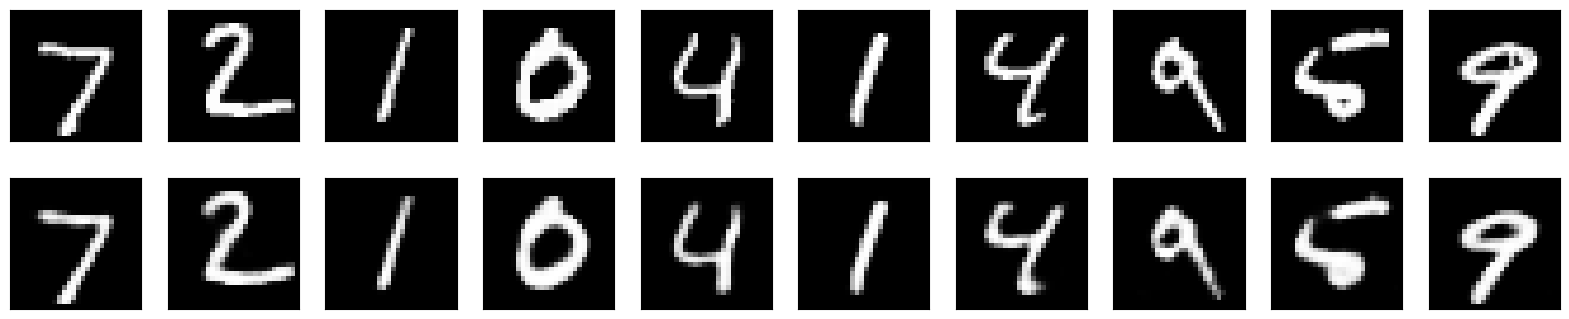

In [13]:
# plot best model decoded images
x_train, x_val, x_test = x_d_train, x_d_val, x_d_test
model = load_model('model_' + 'dense_' + str(study_dense.best_trial.number) + '.keras')
decoded_imgs = model.predict(x_test)
print_digits(decoded_imgs, x_test)

In [14]:
print(study_dense.best_params)
print(study_dense.best_value)
print(study_dense.best_trial)

{'num_layers': 2, 'dim_0': 213, 'dim_1': 46, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 128}
0.07535693049430847
FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.07535693049430847], datetime_start=datetime.datetime(2023, 12, 24, 10, 47, 40, 953006), datetime_complete=datetime.datetime(2023, 12, 24, 10, 49, 0, 591136), params={'num_layers': 2, 'dim_0': 213, 'dim_1': 46, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 2, 'batch_size': 128}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=5, log=False, low=2, step=1), 'dim_0': IntDistribution(high=512, log=False, low=50, step=1), 'dim_1': IntDistribution(high=50, log=False, low=10, step=1), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'gelu')), 'optimizer': CategoricalDistribution(choices=('adam', 'adagrad', 'adadelta', 'adamax', 'nadam')), 'patience': IntDistribution(high=10, log=False, low=1, step=1), 'batch_size': 

In [15]:
df_dense = study_dense.trials_dataframe()

df_dense_sorted = df_dense.copy(deep=True)
df_dense_sorted = df_dense_sorted.dropna(subset=['value'])
df_dense_sorted = df_dense_sorted.sort_values(by=['value'], ascending=True)
df_dense_sorted = df_dense_sorted.reset_index(drop=True)
df_dense_sorted

,number,value,datetime_start,datetime_complete,duration,params_activation,params_batch_size,params_dim_0,params_dim_1,params_dim_2,params_dim_3,params_dim_4,params_num_layers,params_optimizer,params_patience,state
0,1,0.075357,2023-12-24 10:47:40.953006,2023-12-24 10:49:00.591136,0 days 00:01:19.638130,relu,128,213,46,NaN,NaN,NaN,2,nadam,2,COMPLETE
1,5,0.075968,2023-12-24 10:54:36.852343,2023-12-24 11:00:29.508269,0 days 00:05:52.655926,gelu,32,398,137,45.0,NaN,NaN,4,nadam,2,COMPLETE
2,7,0.076698,2023-12-24 11:01:23.539340,2023-12-24 11:02:41.594368,0 days 00:01:18.055028,elu,64,292,50,NaN,NaN,NaN,3,nadam,1,COMPLETE
3,22,0.077473,2023-12-24 11:40:38.693670,2023-12-24 11:44:02.585995,0 days 00:03:23.892325,elu,64,149,43,NaN,NaN,NaN,3,nadam,3,COMPLETE
4,14,0.077746,2023-12-24 11:16:14.419636,2023-12-24 11:21:15.461516,0 days 00:05:01.041880,relu,32,405,196,89.0,43.0,NaN,4,adamax,4,COMPLETE
5,40,0.078133,2023-12-24 12:26:54.442116,2023-12-24 12:29:38.261021,0 days 00:02:43.818905,gelu,64,334,37,NaN,NaN,NaN,2,nadam,10,COMPLETE
6,34,0.078447,2023-12-24 12:12:18.142046,2023-12-24 12:17:41.865666,0 days 00:05:23.723620,elu,32,216,72,42.0,NaN,NaN,3,adamax,2,COMPLETE
7,42,0.078470,2023-12-24 12:34:44.629821,2023-12-24 12:40:08.578056,0 days 00:05:23.948235,relu,32,384,188,123.0,44.0,NaN,4,adamax,4,COMPLETE
8,27,0.078643,2023-12-24 11:52:45.948412,2023-12-24 11:58:22.920112,0 days 00:05:36.971700,relu,32,457,248,41.0,NaN,NaN,3,nadam,5,COMPLETE
9,41,0.078742,2023-12-24 12:29:38.262629,2023-12-24 12:34:44.627839,0 days 00:05:06.365210,relu,32,408,220,147.0,38.0,NaN,4,adamax,4,COMPLETE


In [16]:
plot_optimization_history(study_dense)

In [17]:
plot_slice(study_dense)

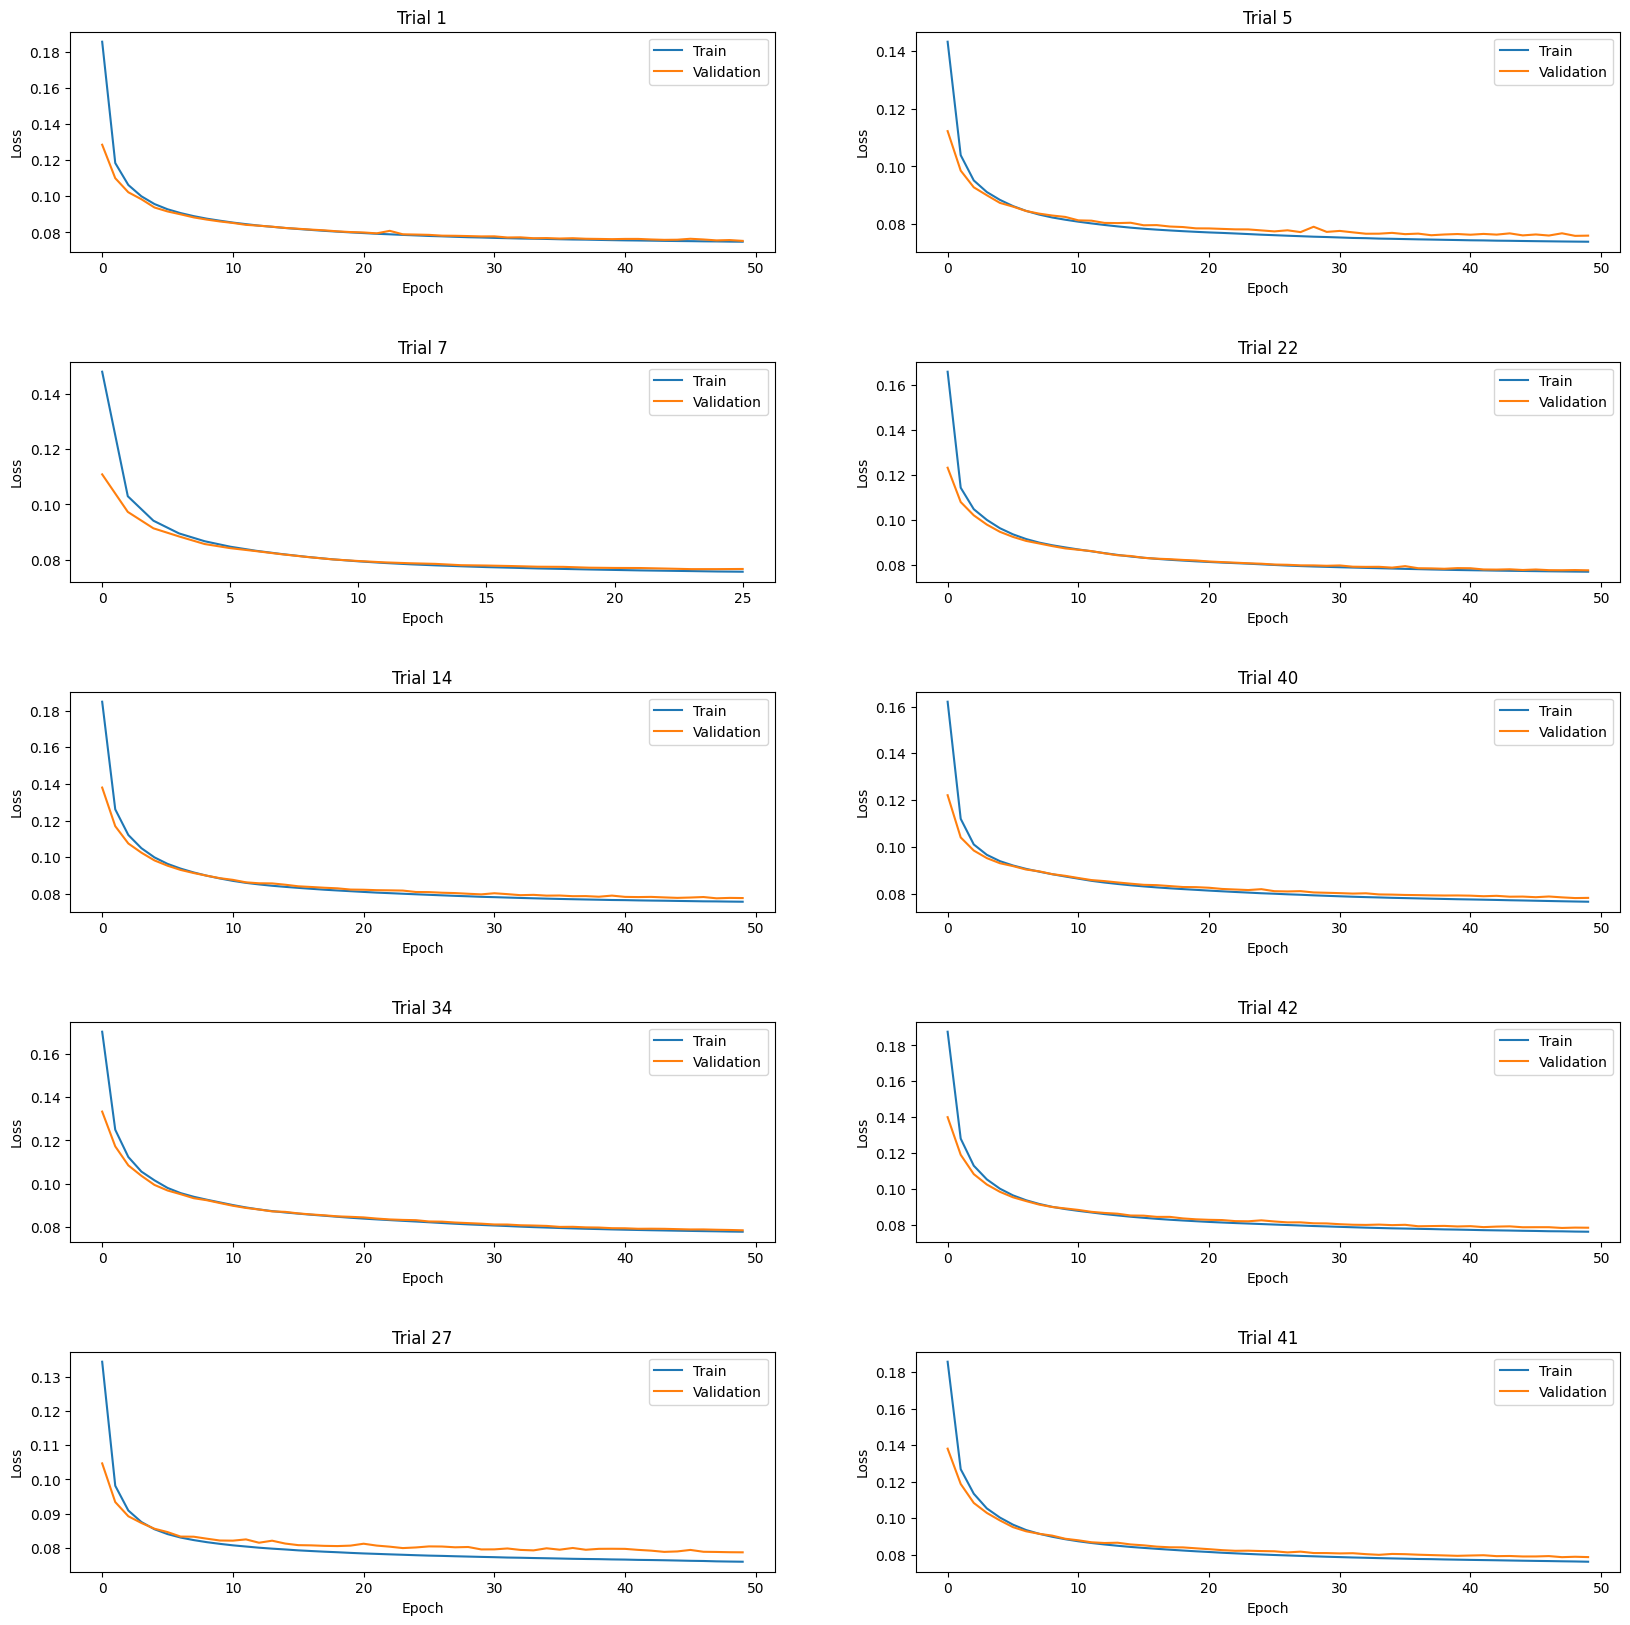

In [18]:
path = '/kaggle/working/'

sorted_trials = sorted([trial for trial in study_dense.trials if trial.value is not None], key=lambda trial: trial.value)
plt.figure(figsize=(20, 20))
for i, trial in enumerate(sorted_trials[:10]):
    history = np.load('history_' + 'dense_' + str(trial.number) + '.npy', allow_pickle=True).item()
    plt.subplot(5, 2, i + 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Trial ' + str(trial.number))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.subplots_adjust(hspace=0.5)
plt.show()

# Optimizing the Convolutional Autoencoder

To skip logs click [here](#Convolutional-Autoencoder-optimization-results).

In [19]:
def objective_conv(trial):
    dim_list = []
    layers = trial.suggest_int('num_layers', 4, 6)
    x_train, x_val, x_test = x_c_train, x_c_val, x_c_test
    kernel_size = 3
    pool_size = 2
    padding = 'same'
    for i in range(layers):
        if i == 0:
            dim_list.append([trial.suggest_int('filters_' + str(i), 16, 64), (kernel_size, kernel_size), (pool_size, pool_size), padding])
        elif i == layers - 1:
            dim_list.append([(kernel_size, kernel_size), padding])
        else:
            # take min filters size from list
            min_element = min([dim_list[i][0] for i in range(len(dim_list))])
            dim_list.append([trial.suggest_int('filters_' + str(i), 8, min_element), (kernel_size, kernel_size), (pool_size, pool_size), padding])
    print('Dim list:', dim_list)
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'gelu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    loss = 'binary_crossentropy'
    patience = trial.suggest_int('patience', 1, 10)
    autoencoder = Autoencoder('conv', dim_list, activation, optimizer, loss, patience)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    history = autoencoder.fit(x_train, x_train,
                              epochs=50,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_val, x_val),
                              callbacks=[autoencoder.es])
    save_model(autoencoder, 'model_' + 'conv_' + str(trial.number) + '.keras')
    np.save('history_' + 'conv_' + str(trial.number) + '.npy', history.history)
    encoded_imgs = autoencoder.encode(x_test)
    print('Shape of encoded vector:', encoded_imgs.shape)
    flattened_size = 1
    for dim in encoded_imgs.shape[1:]:
        flattened_size *= dim

    # constraint: flatten size must be less than 50
    c0 = flattened_size - 50
    trial.set_user_attr('constraint', [c0])

    print('######################')
    return history.history['val_loss'][-1] # return validation loss of last epoch

def constraints(trial):
    return trial.user_attrs['constraint']

In [20]:
sampler = optuna.samplers.NSGAIISampler(constraints_func=constraints)
study_conv = optuna.create_study(direction='minimize', sampler=sampler)
study_conv.optimize(objective_conv, n_trials=50, n_jobs=1)

/opt/conda/lib/python3.10/site-packages/optuna/samplers/nsgaii/_sampler.py:162: ExperimentalWarning:

The constraints_func option is an experimental feature. The interface can change in the future.

[I 2023-12-24 13:05:42,971] A new study created in memory with name: no-name-6a417545-e2ce-4d60-9b39-98d7b3c96afc


Dim list: [[39, (3, 3), (2, 2), 'same'], [31, (3, 3), (2, 2), 'same'], [23, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 11s 34ms/step - loss: 0.2658 - val_loss: 0.1700
Epoch 2/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1506 - val_loss: 0.1336
Epoch 3/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1264 - val_loss: 0.1218
Epoch 4/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1159 - val_loss: 0.1117
Epoch 5/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1093 - val_loss: 0.1069
Epoch 6/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1049 - val_loss: 0.1025
Epoch 7/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1016 - val_loss: 0.0996
Epoch 8/50
94/94 [==============================] - 2s 22ms/step - loss: 0.0992 - val_loss: 0.0980
Epoch 9/50
94/94 [==============================] - 2s 22ms/step - loss: 0.0970 - val_lo

[I 2023-12-24 13:08:09,295] Trial 0 finished with value: 0.07788873463869095 and parameters: {'num_layers': 4, 'filters_0': 39, 'filters_1': 31, 'filters_2': 23, 'activation': 'relu', 'optimizer': 'adam', 'patience': 4, 'batch_size': 512}. Best is trial 0 with value: 0.07788873463869095.


Shape of encoded vector: (10000, 4, 4, 23)
######################
Dim list: [[42, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 8s 7ms/step - loss: 0.1582 - val_loss: 0.1178
Epoch 2/50
750/750 [==============================] - 5s 6ms/step - loss: 0.1101 - val_loss: 0.1043
Epoch 3/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1003 - val_loss: 0.0964
Epoch 4/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0949 - val_loss: 0.0926
Epoch 5/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0916 - val_loss: 0.0904
Epoch 6/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0893 - val_loss: 0.0884
Epoch 7/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0875 - val_loss: 0.0864
Epoch 8/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0859 - val_loss: 0.0852
Epoch 9/50
750/

[I 2023-12-24 13:11:33,592] Trial 1 finished with value: 0.07465874403715134 and parameters: {'num_layers': 4, 'filters_0': 42, 'filters_1': 14, 'filters_2': 13, 'activation': 'elu', 'optimizer': 'adam', 'patience': 9, 'batch_size': 64}. Best is trial 1 with value: 0.07465874403715134.


Shape of encoded vector: (10000, 4, 4, 13)
######################
Dim list: [[43, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 9s 7ms/step - loss: 0.6467 - val_loss: 0.6047
Epoch 2/50
750/750 [==============================] - 5s 6ms/step - loss: 0.5472 - val_loss: 0.4842
Epoch 3/50
750/750 [==============================] - 5s 6ms/step - loss: 0.4410 - val_loss: 0.4152
Epoch 4/50
750/750 [==============================] - 5s 7ms/step - loss: 0.4112 - val_loss: 0.4083
Epoch 5/50
750/750 [==============================] - 6s 7ms/step - loss: 0.4080 - val_loss: 0.4063
Epoch 6/50
750/750 [==============================] - 5s 7ms/step - loss: 0.4063 - val_loss: 0.4047
Epoch 7/50
750/750 [==============================] - 5s 6ms/step - loss: 0.4048 - val_loss: 0.4033
Epoch 8/50
750/750 [==============================] - 5s 6ms/step - loss: 0.4033 - va

[I 2023-12-24 13:15:59,256] Trial 2 finished with value: 0.2503415644168854 and parameters: {'num_layers': 5, 'filters_0': 43, 'filters_1': 13, 'filters_2': 12, 'filters_3': 10, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 2, 'batch_size': 64}. Best is trial 1 with value: 0.07465874403715134.


Shape of encoded vector: (10000, 2, 2, 10)
######################
Dim list: [[31, (3, 3), (2, 2), 'same'], [25, (3, 3), (2, 2), 'same'], [25, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
375/375 [==============================] - 9s 12ms/step - loss: 0.1842 - val_loss: 0.1267
Epoch 2/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1177 - val_loss: 0.1086
Epoch 3/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1048 - val_loss: 0.0996
Epoch 4/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0981 - val_loss: 0.0949
Epoch 5/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0938 - val_loss: 0.0944
Epoch 6/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0908 - val_loss: 0.0884
Epoch 7/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0885 - val_loss: 0.0868
Epoch 8/50
375/375 [==============================] - 4s 11ms/step - loss: 0.0866 - val_loss: 0.0885
Epoch 9

[I 2023-12-24 13:19:24,944] Trial 3 finished with value: 0.07150404155254364 and parameters: {'num_layers': 4, 'filters_0': 31, 'filters_1': 25, 'filters_2': 25, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 9, 'batch_size': 128}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 25)
######################
Dim list: [[34, (3, 3), (2, 2), 'same'], [23, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 16s 7ms/step - loss: 0.6895 - val_loss: 0.6848
Epoch 2/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.6779 - val_loss: 0.6693
Epoch 3/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.6561 - val_loss: 0.6389
Epoch 4/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.6095 - val_loss: 0.5705
Epoch 5/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.5143 - val_loss: 0.4578
Epoch 6/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4321 - val_loss: 0.4194
Epoch 7/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4179 - val_loss: 0.4158
Epoch 8/50
1500/1500 [=============

[I 2023-12-24 13:28:51,304] Trial 4 finished with value: 0.276032418012619 and parameters: {'num_layers': 6, 'filters_0': 34, 'filters_1': 23, 'filters_2': 13, 'filters_3': 10, 'filters_4': 8, 'activation': 'gelu', 'optimizer': 'adadelta', 'patience': 7, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[64, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
375/375 [==============================] - 8s 14ms/step - loss: 0.6637 - val_loss: 0.6409
Epoch 2/50
375/375 [==============================] - 5s 13ms/step - loss: 0.6174 - val_loss: 0.5910
Epoch 3/50
375/375 [==============================] - 5s 13ms/step - loss: 0.5593 - val_loss: 0.5243
Epoch 4/50
375/375 [==============================] - 5s 13ms/step - loss: 0.4891 - val_loss: 0.4561
Epoch 5/50
375/375 [==============================] - 5s 13ms/step - loss: 0.4376 - val_loss: 0.4251
Epoch 6/50
375/375 [==============================] - 5s 13ms/step - loss: 0.4218 - val_loss: 0.4184
Epoch 7/50
375/375 [==============================] - 5s 13ms/step - loss: 0.4173 - val_loss: 0.4149
Epoch 8/50
375/375 [==============================] - 5s 13ms/step - loss: 0.4143 - val_loss: 0.4122
Epoch 9/

[I 2023-12-24 13:32:57,351] Trial 5 finished with value: 0.17704863846302032 and parameters: {'num_layers': 4, 'filters_0': 64, 'filters_1': 13, 'filters_2': 12, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 6, 'batch_size': 128}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 12)
######################
Dim list: [[52, (3, 3), (2, 2), 'same'], [24, (3, 3), (2, 2), 'same'], [21, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 8s 48ms/step - loss: 0.6913 - val_loss: 0.6891
Epoch 2/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6869 - val_loss: 0.6844
Epoch 3/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6817 - val_loss: 0.6788
Epoch 4/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6754 - val_loss: 0.6717
Epoch 5/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6674 - val_loss: 0.6626
Epoch 6/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6568 - val_loss: 0.6503
Epoch 7/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6424 - val_loss: 0.6333
Epoch 8/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6224 - val_loss: 

[I 2023-12-24 13:35:23,426] Trial 6 finished with value: 0.2835675776004791 and parameters: {'num_layers': 5, 'filters_0': 52, 'filters_1': 24, 'filters_2': 21, 'filters_3': 12, 'activation': 'elu', 'optimizer': 'adadelta', 'patience': 6, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 12)
######################
Dim list: [[28, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 9s 5ms/step - loss: 0.5087 - val_loss: 0.4044
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3112 - val_loss: 0.2505
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2356 - val_loss: 0.2234
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2166 - val_loss: 0.2080
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2029 - val_loss: 0.1967
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1940 - val_loss: 0.1896
Epoch 7/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1879 - val_loss: 0.1842
Epoch 8/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1829 - val_loss: 0.1797

[I 2023-12-24 13:41:16,668] Trial 7 finished with value: 0.13205689191818237 and parameters: {'num_layers': 4, 'filters_0': 28, 'filters_1': 13, 'filters_2': 13, 'activation': 'relu', 'optimizer': 'adagrad', 'patience': 3, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 13)
######################
Dim list: [[37, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 6s 14ms/step - loss: 0.2672 - val_loss: 0.1806
Epoch 2/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1647 - val_loss: 0.1513
Epoch 3/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1445 - val_loss: 0.1374
Epoch 4/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1333 - val_loss: 0.1285
Epoch 5/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1259 - val_loss: 0.1225
Epoch 6/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1205 - val_loss: 0.1179
Epoch 7/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1164 - val_loss: 0.1143
Epoch 8/50
188/188 [==============================] - 2s 10ms/step - loss: 0.1134 - val_loss: 0.1118
Epoch 9

[I 2023-12-24 13:42:56,786] Trial 8 finished with value: 0.08638624846935272 and parameters: {'num_layers': 4, 'filters_0': 37, 'filters_1': 14, 'filters_2': 13, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 6, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 13)
######################
Dim list: [[20, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 11s 8ms/step - loss: 0.2141 - val_loss: 0.1739
Epoch 2/50
750/750 [==============================] - 5s 7ms/step - loss: 0.1640 - val_loss: 0.1549
Epoch 3/50
750/750 [==============================] - 6s 7ms/step - loss: 0.1526 - val_loss: 0.1495
Epoch 4/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1459 - val_loss: 0.1420
Epoch 5/50
750/750 [==============================] - 6s 7ms/step - loss: 0.1410 - val_loss: 0.1386
Epoch 6/50
750/750 [==============================] - 5s 7ms/step - loss: 0.1370 - val_loss: 0.1335
Epoch 7/50
750/750 [==============================] - 5s 7ms/step - loss: 0.1338 - val_loss: 0.1309
Epoch 8/50
750/750 [==============================] - 5s 7ms/step - loss: 0.1313 - val_

[I 2023-12-24 13:47:21,687] Trial 9 finished with value: 0.10887780785560608 and parameters: {'num_layers': 5, 'filters_0': 20, 'filters_1': 9, 'filters_2': 8, 'filters_3': 8, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 5, 'batch_size': 64}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 8)
######################
Dim list: [[28, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 7s 14ms/step - loss: 0.2749 - val_loss: 0.2232
Epoch 2/50
188/188 [==============================] - 2s 9ms/step - loss: 0.2092 - val_loss: 0.1954
Epoch 3/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1871 - val_loss: 0.1771
Epoch 4/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1722 - val_loss: 0.1663
Epoch 5/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1624 - val_loss: 0.1575
Epoch 6/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1558 - val_loss: 0.1523
Epoch 7/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1505 - val_loss: 0.1475
Epoch 8/50
188/188 [==============================] - 2s 9ms/step - loss: 0.1465 - val

[I 2023-12-24 13:48:52,800] Trial 10 finished with value: 0.10762675106525421 and parameters: {'num_layers': 5, 'filters_0': 28, 'filters_1': 12, 'filters_2': 10, 'filters_3': 9, 'activation': 'elu', 'optimizer': 'adam', 'patience': 8, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 9)
######################
Dim list: [[38, (3, 3), (2, 2), 'same'], [34, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 9s 7ms/step - loss: 0.6766 - val_loss: 0.6546
Epoch 2/50
750/750 [==============================] - 5s 6ms/step - loss: 0.5721 - val_loss: 0.4679
Epoch 3/50
750/750 [==============================] - 5s 7ms/step - loss: 0.4504 - val_loss: 0.4379
Epoch 4/50
750/750 [==============================] - 5s 6ms/step - loss: 0.4242 - val_loss: 0.4057
Epoch 5/50
750/750 [==============================] - 5s 6ms/step - loss: 0.3773 - val_loss: 0.3422
Epoch 6/50
750/750 [==============================] - 5s 6ms/step - loss: 0.3162 - val_loss: 0.2985
Epoch 7/50
750/750 [==============================] - 5s 6ms/step - loss: 0.2938 - val_loss: 0.2893
Epoch 8/50
750/750 [==============================] - 5s 

[I 2023-12-24 13:53:18,914] Trial 11 finished with value: 0.25290486216545105 and parameters: {'num_layers': 6, 'filters_0': 38, 'filters_1': 34, 'filters_2': 13, 'filters_3': 11, 'filters_4': 8, 'activation': 'elu', 'optimizer': 'adadelta', 'patience': 4, 'batch_size': 64}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[55, (3, 3), (2, 2), 'same'], [40, (3, 3), (2, 2), 'same'], [28, (3, 3), (2, 2), 'same'], [28, (3, 3), (2, 2), 'same'], [25, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
375/375 [==============================] - 9s 12ms/step - loss: 0.2279 - val_loss: 0.1663
Epoch 2/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1463 - val_loss: 0.1331
Epoch 3/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1265 - val_loss: 0.1197
Epoch 4/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1170 - val_loss: 0.1126
Epoch 5/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1111 - val_loss: 0.1077
Epoch 6/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1071 - val_loss: 0.1054
Epoch 7/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1040 - val_loss: 0.1018
Epoch 8/50
375/375 [=============================

[I 2023-12-24 13:56:44,427] Trial 12 finished with value: 0.08195627480745316 and parameters: {'num_layers': 6, 'filters_0': 55, 'filters_1': 40, 'filters_2': 28, 'filters_3': 28, 'filters_4': 25, 'activation': 'elu', 'optimizer': 'adam', 'patience': 6, 'batch_size': 128}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 25)
######################
Dim list: [[48, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 11s 33ms/step - loss: 0.3817 - val_loss: 0.2657
Epoch 2/50
188/188 [==============================] - 4s 23ms/step - loss: 0.2491 - val_loss: 0.2367
Epoch 3/50
188/188 [==============================] - 4s 23ms/step - loss: 0.2271 - val_loss: 0.2151
Epoch 4/50
188/188 [==============================] - 4s 23ms/step - loss: 0.2121 - val_loss: 0.2056
Epoch 5/50
188/188 [==============================] - 4s 23ms/step - loss: 0.2002 - val_loss: 0.1941
Epoch 6/50
188/188 [==============================] - 4s 23ms/step - loss: 0.1925 - val_loss: 0.1891
Epoch 7/50
188/188 [==============================] - 4s 23ms/step - loss: 0.1874 - val_loss: 0.1837
Epoch 8/50
188/188 [===========================

[I 2023-12-24 14:00:27,331] Trial 13 finished with value: 0.14256711304187775 and parameters: {'num_layers': 6, 'filters_0': 48, 'filters_1': 18, 'filters_2': 14, 'filters_3': 11, 'filters_4': 11, 'activation': 'gelu', 'optimizer': 'adamax', 'patience': 7, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 11)
######################
Dim list: [[28, (3, 3), (2, 2), 'same'], [22, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 14s 6ms/step - loss: 0.2312 - val_loss: 0.1922
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1860 - val_loss: 0.1810
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1790 - val_loss: 0.1767
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1754 - val_loss: 0.1734
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1730 - val_loss: 0.1709
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1708 - val_loss: 0.1690
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1693 - val_loss: 0.1678
Epoch 8/50
1500/1500 [===================

[I 2023-12-24 14:08:18,192] Trial 14 finished with value: 0.13837537169456482 and parameters: {'num_layers': 6, 'filters_0': 28, 'filters_1': 22, 'filters_2': 15, 'filters_3': 15, 'filters_4': 8, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 9, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[52, (3, 3), (2, 2), 'same'], [32, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 11s 9ms/step - loss: 0.2206 - val_loss: 0.1635
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1457 - val_loss: 0.1345
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1291 - val_loss: 0.1235
Epoch 4/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1209 - val_loss: 0.1171
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1158 - val_loss: 0.1123
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1121 - val_loss: 0.1105
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1093 - val_loss: 0.1102
Epoch 8/50
750/750 [==============================] - 6s 7ms/step - loss: 0.1071 - val

[I 2023-12-24 14:12:31,662] Trial 15 finished with value: 0.08753132820129395 and parameters: {'num_layers': 5, 'filters_0': 52, 'filters_1': 32, 'filters_2': 10, 'filters_3': 9, 'activation': 'gelu', 'optimizer': 'adam', 'patience': 1, 'batch_size': 64}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 9)
######################
Dim list: [[31, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 9s 7ms/step - loss: 0.2650 - val_loss: 0.2219
Epoch 2/50
750/750 [==============================] - 5s 7ms/step - loss: 0.2072 - val_loss: 0.1972
Epoch 3/50
750/750 [==============================] - 5s 6ms/step - loss: 0.1944 - val_loss: 0.1897
Epoch 4/50
750/750 [==============================] - 5s 6ms/step - loss: 0.1874 - val_loss: 0.1827
Epoch 5/50
750/750 [==============================] - 5s 6ms/step - loss: 0.1800 - val_loss: 0.1758
Epoch 6/50
750/750 [==============================] - 5s 6ms/step - loss: 0.1744 - val_loss: 0.1711
Epoch 7/50
750/750 [==============================] - 5s 6ms/step - loss: 0.1705 - val_loss: 0.1681
Epoch 8/50
750/750 [==============================] - 5s 7ms

[I 2023-12-24 14:16:38,244] Trial 16 finished with value: 0.13348345458507538 and parameters: {'num_layers': 6, 'filters_0': 31, 'filters_1': 8, 'filters_2': 8, 'filters_3': 8, 'filters_4': 8, 'activation': 'elu', 'optimizer': 'adamax', 'patience': 8, 'batch_size': 64}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[27, (3, 3), (2, 2), 'same'], [24, (3, 3), (2, 2), 'same'], [16, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 9s 43ms/step - loss: 0.6849 - val_loss: 0.6787
Epoch 2/50
94/94 [==============================] - 3s 29ms/step - loss: 0.6740 - val_loss: 0.6695
Epoch 3/50
94/94 [==============================] - 3s 30ms/step - loss: 0.6654 - val_loss: 0.6612
Epoch 4/50
94/94 [==============================] - 3s 30ms/step - loss: 0.6572 - val_loss: 0.6530
Epoch 5/50
94/94 [==============================] - 3s 30ms/step - loss: 0.6488 - val_loss: 0.6444
Epoch 6/50
94/94 [==============================] - 3s 30ms/step - loss: 0.6399 - val_loss: 0.6350
Epoch 7/50
94/94 [==============================] - 3s 30ms/step - loss: 0.6301 - val_loss: 0.6247
Epoch 8/50
94/94 [==============================] - 3s 30ms/ste

[I 2023-12-24 14:19:05,207] Trial 17 finished with value: 0.40479224920272827 and parameters: {'num_layers': 6, 'filters_0': 27, 'filters_1': 24, 'filters_2': 16, 'filters_3': 15, 'filters_4': 12, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 3, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 12)
######################
Dim list: [[56, (3, 3), (2, 2), 'same'], [19, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 7s 37ms/step - loss: 0.6767 - val_loss: 0.6634
Epoch 2/50
94/94 [==============================] - 2s 24ms/step - loss: 0.6523 - val_loss: 0.6407
Epoch 3/50
94/94 [==============================] - 2s 24ms/step - loss: 0.6282 - val_loss: 0.6141
Epoch 4/50
94/94 [==============================] - 2s 24ms/step - loss: 0.5984 - val_loss: 0.5805
Epoch 5/50
94/94 [==============================] - 2s 24ms/step - loss: 0.5608 - val_loss: 0.5390
Epoch 6/50
94/94 [==============================] - 2s 24ms/step - loss: 0.5168 - val_loss: 0.4937
Epoch 7/50
94/94 [==============================] - 2s 24ms/step - loss: 0.4742 - val_loss: 0.4558
Epoch 8/50
94/94 [==============================] - 2s 24ms/st

[I 2023-12-24 14:21:06,242] Trial 18 finished with value: 0.26751843094825745 and parameters: {'num_layers': 6, 'filters_0': 56, 'filters_1': 19, 'filters_2': 14, 'filters_3': 12, 'filters_4': 12, 'activation': 'relu', 'optimizer': 'adagrad', 'patience': 10, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 12)
######################
Dim list: [[59, (3, 3), (2, 2), 'same'], [46, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 13s 6ms/step - loss: 0.1663 - val_loss: 0.1261
Epoch 2/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1183 - val_loss: 0.1118
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1082 - val_loss: 0.1046
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1022 - val_loss: 0.1007
Epoch 5/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0987 - val_loss: 0.0972
Epoch 6/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0962 - val_loss: 0.0951
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0943 - val_loss: 0.0923
Epoch 8/50
1500/1500 [==============================] - 8s 6ms/step - l

[I 2023-12-24 14:28:26,912] Trial 19 finished with value: 0.08108670264482498 and parameters: {'num_layers': 5, 'filters_0': 59, 'filters_1': 46, 'filters_2': 15, 'filters_3': 8, 'activation': 'elu', 'optimizer': 'adam', 'patience': 3, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 8)
######################
Dim list: [[41, (3, 3), (2, 2), 'same'], [25, (3, 3), (2, 2), 'same'], [20, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 12s 55ms/step - loss: 0.4746 - val_loss: 0.3553
Epoch 2/50
94/94 [==============================] - 4s 40ms/step - loss: 0.2892 - val_loss: 0.2726
Epoch 3/50
94/94 [==============================] - 4s 40ms/step - loss: 0.2659 - val_loss: 0.2594
Epoch 4/50
94/94 [==============================] - 4s 40ms/step - loss: 0.2579 - val_loss: 0.2551
Epoch 5/50
94/94 [==============================] - 4s 41ms/step - loss: 0.2544 - val_loss: 0.2521
Epoch 6/50
94/94 [==============================] - 4s 41ms/step - loss: 0.2512 - val_loss: 0.2478
Epoch 7/50
94/94 [==============================] - 4s 41ms/step - loss: 0.2452 - val_loss: 0.2404
Epoch 8/50
94/94 [==============================] - 4s 41ms/ste

[I 2023-12-24 14:31:48,565] Trial 20 finished with value: 0.13804666697978973 and parameters: {'num_layers': 6, 'filters_0': 41, 'filters_1': 25, 'filters_2': 20, 'filters_3': 13, 'filters_4': 9, 'activation': 'gelu', 'optimizer': 'adamax', 'patience': 6, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 9)
######################
Dim list: [[23, (3, 3), (2, 2), 'same'], [23, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 5s 24ms/step - loss: 0.3248 - val_loss: 0.1876
Epoch 2/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1630 - val_loss: 0.1451
Epoch 3/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1368 - val_loss: 0.1287
Epoch 4/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1250 - val_loss: 0.1206
Epoch 5/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1185 - val_loss: 0.1154
Epoch 6/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1139 - val_loss: 0.1115
Epoch 7/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1108 - val_loss: 0.1097
Epoch 8/50
94/94 [==============================] - 2s 17ms/step - loss: 0.1080 - val_loss: 0.1065
Epoch 9/50
94/94 [======

[I 2023-12-24 14:33:01,686] Trial 21 finished with value: 0.08582412451505661 and parameters: {'num_layers': 4, 'filters_0': 23, 'filters_1': 23, 'filters_2': 15, 'activation': 'relu', 'optimizer': 'adam', 'patience': 4, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 15)
######################
Dim list: [[32, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 12s 9ms/step - loss: 0.2039 - val_loss: 0.1614
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1523 - val_loss: 0.1438
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1405 - val_loss: 0.1355
Epoch 4/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1341 - val_loss: 0.1299
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1294 - val_loss: 0.1254
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1253 - val_loss: 0.1217
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1223 - val_loss: 0.1206
Epoch 8/50
750/750 [==============================] - 6s 8ms/step - loss: 0.1195 - va

[I 2023-12-24 14:38:08,345] Trial 22 finished with value: 0.0948755070567131 and parameters: {'num_layers': 5, 'filters_0': 32, 'filters_1': 18, 'filters_2': 13, 'filters_3': 8, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 10, 'batch_size': 64}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 8)
######################
Dim list: [[36, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 15s 7ms/step - loss: 0.5857 - val_loss: 0.4647
Epoch 2/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4203 - val_loss: 0.4079
Epoch 3/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4067 - val_loss: 0.4041
Epoch 4/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4031 - val_loss: 0.4005
Epoch 5/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3990 - val_loss: 0.3956
Epoch 6/50
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3924 - val_loss: 0.3866
Epoch 7/50
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3786 - val_loss: 0.3662
Epoch 8/50
1500/1500 [==============

[I 2023-12-24 14:46:51,895] Trial 23 finished with value: 0.25371915102005005 and parameters: {'num_layers': 6, 'filters_0': 36, 'filters_1': 15, 'filters_2': 15, 'filters_3': 11, 'filters_4': 8, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 9, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[25, (3, 3), (2, 2), 'same'], [24, (3, 3), (2, 2), 'same'], [16, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 6s 26ms/step - loss: 0.3512 - val_loss: 0.2561
Epoch 2/50
94/94 [==============================] - 1s 16ms/step - loss: 0.2311 - val_loss: 0.2086
Epoch 3/50
94/94 [==============================] - 1s 15ms/step - loss: 0.1965 - val_loss: 0.1837
Epoch 4/50
94/94 [==============================] - 1s 15ms/step - loss: 0.1780 - val_loss: 0.1710
Epoch 5/50
94/94 [==============================] - 1s 16ms/step - loss: 0.1665 - val_loss: 0.1614
Epoch 6/50
94/94 [==============================] - 1s 15ms/step - loss: 0.1585 - val_loss: 0.1541
Epoch 7/50
94/94 [==============================] - 1s 15ms/step - loss: 0.1527 - val_loss: 0.1489
Epoch 8/50
94/94 [==============================] - 1s 15ms/step - loss: 0.1478 - val_loss: 0.

[I 2023-12-24 14:48:10,605] Trial 24 finished with value: 0.10991921275854111 and parameters: {'num_layers': 5, 'filters_0': 25, 'filters_1': 24, 'filters_2': 16, 'filters_3': 9, 'activation': 'relu', 'optimizer': 'adam', 'patience': 6, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 9)
######################
Dim list: [[41, (3, 3), (2, 2), 'same'], [28, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 8s 26ms/step - loss: 0.6737 - val_loss: 0.6594
Epoch 2/50
188/188 [==============================] - 4s 21ms/step - loss: 0.6479 - val_loss: 0.6363
Epoch 3/50
188/188 [==============================] - 4s 21ms/step - loss: 0.6247 - val_loss: 0.6124
Epoch 4/50
188/188 [==============================] - 4s 21ms/step - loss: 0.5995 - val_loss: 0.5855
Epoch 5/50
188/188 [==============================] - 4s 21ms/step - loss: 0.5709 - val_loss: 0.5551
Epoch 6/50
188/188 [==============================] - 4s 21ms/step - loss: 0.5390 - val_loss: 0.5219
Epoch 7/50
188/188 [==============================] - 4s 21ms/step - loss: 0.5055 - val_loss: 0.4886
Epoch 8/50
188/188 [==============================] - 4s 21ms/step - loss: 0.4738 - val_loss: 0.4590
Epoch 9/5

[I 2023-12-24 14:51:36,810] Trial 25 finished with value: 0.2281557023525238 and parameters: {'num_layers': 4, 'filters_0': 41, 'filters_1': 28, 'filters_2': 8, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 5, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 8)
######################
Dim list: [[51, (3, 3), (2, 2), 'same'], [46, (3, 3), (2, 2), 'same'], [24, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 7s 43ms/step - loss: 0.6698 - val_loss: 0.6501
Epoch 2/50
94/94 [==============================] - 3s 29ms/step - loss: 0.6308 - val_loss: 0.6090
Epoch 3/50
94/94 [==============================] - 3s 29ms/step - loss: 0.5826 - val_loss: 0.5521
Epoch 4/50
94/94 [==============================] - 3s 29ms/step - loss: 0.5191 - val_loss: 0.4858
Epoch 5/50
94/94 [==============================] - 3s 29ms/step - loss: 0.4644 - val_loss: 0.4485
Epoch 6/50
94/94 [==============================] - 3s 29ms/step - loss: 0.4427 - val_loss: 0.4373
Epoch 7/50
94/94 [==============================] - 3s 29ms/step - loss: 0.4346 - val_loss: 0.4309
Epoch 8/50
94/94 [==============================] - 3s 29ms/step - loss: 0.4289 - val_loss: 0

[I 2023-12-24 14:54:00,292] Trial 26 finished with value: 0.25135430693626404 and parameters: {'num_layers': 5, 'filters_0': 51, 'filters_1': 46, 'filters_2': 24, 'filters_3': 11, 'activation': 'relu', 'optimizer': 'adagrad', 'patience': 1, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 11)
######################
Dim list: [[53, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 6s 32ms/step - loss: 0.3096 - val_loss: 0.1850
Epoch 2/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1663 - val_loss: 0.1519
Epoch 3/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1435 - val_loss: 0.1355
Epoch 4/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1313 - val_loss: 0.1262
Epoch 5/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1238 - val_loss: 0.1206
Epoch 6/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1187 - val_loss: 0.1162
Epoch 7/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1149 - val_loss: 0.1129
Epoch 8/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1123 - val_loss: 0.1110
Epoch 9/50
94/94 [=====

[I 2023-12-24 14:56:25,630] Trial 27 finished with value: 0.08679310232400894 and parameters: {'num_layers': 4, 'filters_0': 53, 'filters_1': 14, 'filters_2': 13, 'activation': 'relu', 'optimizer': 'adam', 'patience': 8, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 13)
######################
Dim list: [[31, (3, 3), (2, 2), 'same'], [28, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 9s 6ms/step - loss: 0.6905 - val_loss: 0.6883
Epoch 2/50
750/750 [==============================] - 4s 6ms/step - loss: 0.6856 - val_loss: 0.6824
Epoch 3/50
750/750 [==============================] - 4s 6ms/step - loss: 0.6786 - val_loss: 0.6742
Epoch 4/50
750/750 [==============================] - 4s 6ms/step - loss: 0.6686 - val_loss: 0.6621
Epoch 5/50
750/750 [==============================] - 4s 6ms/step - loss: 0.6535 - val_loss: 0.6433
Epoch 6/50
750/750 [==============================] - 4s 6ms/step - loss: 0.6290 - val_loss: 0.6115
Epoch 7/50
750/750 [==============================] - 4s 6ms/step - loss: 0.5865 - val_loss: 0.5564
Epoch 8/50
750/750 [==============================] - 4s 6ms/step - loss: 0.5195 - val_loss: 0.4823
Epoch 9/50
750/

[I 2023-12-24 15:00:05,036] Trial 28 finished with value: 0.23559880256652832 and parameters: {'num_layers': 4, 'filters_0': 31, 'filters_1': 28, 'filters_2': 18, 'activation': 'gelu', 'optimizer': 'adadelta', 'patience': 3, 'batch_size': 64}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 18)
######################
Dim list: [[57, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 8s 19ms/step - loss: 0.6945 - val_loss: 0.6933
Epoch 2/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6921 - val_loss: 0.6909
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6896 - val_loss: 0.6883
Epoch 4/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6869 - val_loss: 0.6854
Epoch 5/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6839 - val_loss: 0.6822
Epoch 6/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6804 - val_loss: 0.6784
Epoch 7/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6763 - val_loss: 0.6739
Epoch 8/50
188/188 [==============================] 

[I 2023-12-24 15:02:23,339] Trial 29 finished with value: 0.28654226660728455 and parameters: {'num_layers': 6, 'filters_0': 57, 'filters_1': 8, 'filters_2': 8, 'filters_3': 8, 'filters_4': 8, 'activation': 'elu', 'optimizer': 'adadelta', 'patience': 8, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[47, (3, 3), (2, 2), 'same'], [32, (3, 3), (2, 2), 'same'], [30, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 7s 39ms/step - loss: 0.6868 - val_loss: 0.6822
Epoch 2/50
94/94 [==============================] - 2s 27ms/step - loss: 0.6773 - val_loss: 0.6720
Epoch 3/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6661 - val_loss: 0.6597
Epoch 4/50
94/94 [==============================] - 2s 27ms/step - loss: 0.6525 - val_loss: 0.6446
Epoch 5/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6355 - val_loss: 0.6255
Epoch 6/50
94/94 [==============================] - 3s 27ms/step - loss: 0.6141 - val_loss: 0.6018
Epoch 7/50
94/94 [==============================] - 3s 27ms/step - loss: 0.5883 - val_loss: 0.5740
Epoch 8/50
94/94 [==============================] - 3s 27ms/step - loss: 0.5597 - val_loss: 0.5452
Epoch 9/50
94/94 [======

[I 2023-12-24 15:04:36,068] Trial 30 finished with value: 0.2504892945289612 and parameters: {'num_layers': 4, 'filters_0': 47, 'filters_1': 32, 'filters_2': 30, 'activation': 'elu', 'optimizer': 'adadelta', 'patience': 9, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 30)
######################
Dim list: [[46, (3, 3), (2, 2), 'same'], [40, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 10s 32ms/step - loss: 0.6699 - val_loss: 0.6526
Epoch 2/50
188/188 [==============================] - 5s 25ms/step - loss: 0.6386 - val_loss: 0.6244
Epoch 3/50
188/188 [==============================] - 5s 26ms/step - loss: 0.6100 - val_loss: 0.5946
Epoch 4/50
188/188 [==============================] - 5s 26ms/step - loss: 0.5785 - val_loss: 0.5610
Epoch 5/50
188/188 [==============================] - 5s 26ms/step - loss: 0.5431 - val_loss: 0.5241
Epoch 6/50
188/188 [==============================] - 5s 26ms/step - loss: 0.5060 - val_loss: 0.4874
Epoch 7/50
188/188 [==============================] - 5s 26ms/step - loss: 0.4715 - val_loss: 0.4559
Epoch 8/50
188/188 [============================

[I 2023-12-24 15:08:45,414] Trial 31 finished with value: 0.39551180601119995 and parameters: {'num_layers': 6, 'filters_0': 46, 'filters_1': 40, 'filters_2': 11, 'filters_3': 10, 'filters_4': 8, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 4, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[51, (3, 3), (2, 2), 'same'], [37, (3, 3), (2, 2), 'same'], [24, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
375/375 [==============================] - 7s 10ms/step - loss: 0.6200 - val_loss: 0.5353
Epoch 2/50
375/375 [==============================] - 3s 9ms/step - loss: 0.4582 - val_loss: 0.4202
Epoch 3/50
375/375 [==============================] - 3s 9ms/step - loss: 0.4166 - val_loss: 0.4129
Epoch 4/50
375/375 [==============================] - 3s 9ms/step - loss: 0.4108 - val_loss: 0.4069
Epoch 5/50
375/375 [==============================] - 3s 9ms/step - loss: 0.4038 - val_loss: 0.3985
Epoch 6/50
375/375 [==============================] - 3s 9ms/step - loss: 0.3924 - val_loss: 0.3827
Epoch 7/50
375/375 [==============================] - 3s 9ms/step - loss: 0.3699 - val_loss: 0.3528
Epoch 8/50
375/375 [==============================] - 3

[I 2023-12-24 15:11:34,562] Trial 32 finished with value: 0.24107305705547333 and parameters: {'num_layers': 6, 'filters_0': 51, 'filters_1': 37, 'filters_2': 24, 'filters_3': 15, 'filters_4': 13, 'activation': 'relu', 'optimizer': 'adagrad', 'patience': 1, 'batch_size': 128}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 13)
######################
Dim list: [[58, (3, 3), (2, 2), 'same'], [45, (3, 3), (2, 2), 'same'], [26, (3, 3), (2, 2), 'same'], [23, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 9s 25ms/step - loss: 0.2398 - val_loss: 0.1810
Epoch 2/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1572 - val_loss: 0.1403
Epoch 3/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1327 - val_loss: 0.1249
Epoch 4/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1205 - val_loss: 0.1156
Epoch 5/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1137 - val_loss: 0.1097
Epoch 6/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1087 - val_loss: 0.1059
Epoch 7/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1050 - val_loss: 0.1039
Epoch 8/50
188/188 [==============================] - 4s 19ms/step - loss: 0.1

[I 2023-12-24 15:14:39,980] Trial 33 finished with value: 0.07901395112276077 and parameters: {'num_layers': 5, 'filters_0': 58, 'filters_1': 45, 'filters_2': 26, 'filters_3': 23, 'activation': 'elu', 'optimizer': 'adam', 'patience': 3, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 2, 2, 23)
######################
Dim list: [[46, (3, 3), (2, 2), 'same'], [41, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 7s 37ms/step - loss: 0.3499 - val_loss: 0.2057
Epoch 2/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1794 - val_loss: 0.1595
Epoch 3/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1502 - val_loss: 0.1413
Epoch 4/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1361 - val_loss: 0.1305
Epoch 5/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1274 - val_loss: 0.1236
Epoch 6/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1216 - val_loss: 0.1188
Epoch 7/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1176 - val_loss: 0.1154
Epoch 8/50
94/94 [==============================] - 2s 26ms/step - loss: 0.1146 - val_loss: 0.1128
Epoch 9/50
94/94 [=====

[I 2023-12-24 15:16:46,997] Trial 34 finished with value: 0.08694053441286087 and parameters: {'num_layers': 4, 'filters_0': 46, 'filters_1': 41, 'filters_2': 11, 'activation': 'relu', 'optimizer': 'adamax', 'patience': 8, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 11)
######################
Dim list: [[53, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 5s 28ms/step - loss: 0.3754 - val_loss: 0.2083
Epoch 2/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1793 - val_loss: 0.1559
Epoch 3/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1444 - val_loss: 0.1346
Epoch 4/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1302 - val_loss: 0.1249
Epoch 5/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1224 - val_loss: 0.1187
Epoch 6/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1173 - val_loss: 0.1151
Epoch 7/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1138 - val_loss: 0.1116
Epoch 8/50
94/94 [==============================] - 2s 22ms/step - loss: 0.1111 - val_loss: 0.1110
Epoch 9/50
94/94 [=====

[I 2023-12-24 15:19:11,088] Trial 35 finished with value: 0.08910068869590759 and parameters: {'num_layers': 4, 'filters_0': 53, 'filters_1': 14, 'filters_2': 10, 'activation': 'relu', 'optimizer': 'adam', 'patience': 7, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 10)
######################
Dim list: [[49, (3, 3), (2, 2), 'same'], [24, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 9s 5ms/step - loss: 0.4457 - val_loss: 0.3095
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2522 - val_loss: 0.2264
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2193 - val_loss: 0.2110
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2056 - val_loss: 0.1987
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1952 - val_loss: 0.1906
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1885 - val_loss: 0.1850
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1836 - val_loss: 0.1808
Epoch 8/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1798 - val_loss: 0.1774

[I 2023-12-24 15:25:36,480] Trial 36 finished with value: 0.12910129129886627 and parameters: {'num_layers': 4, 'filters_0': 49, 'filters_1': 24, 'filters_2': 13, 'activation': 'relu', 'optimizer': 'adagrad', 'patience': 8, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 13)
######################
Dim list: [[60, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
1500/1500 [==============================] - 11s 5ms/step - loss: 0.1345 - val_loss: 0.1045
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0978 - val_loss: 0.0923
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0896 - val_loss: 0.0872
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0855 - val_loss: 0.0838
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0830 - val_loss: 0.0815
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0812 - val_loss: 0.0802
Epoch 7/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0799 - val_loss: 0.0789
Epoch 8/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0789 - val_loss: 0.078

[I 2023-12-24 15:32:03,148] Trial 37 finished with value: 0.07162275910377502 and parameters: {'num_layers': 4, 'filters_0': 60, 'filters_1': 18, 'filters_2': 13, 'activation': 'elu', 'optimizer': 'adam', 'patience': 3, 'batch_size': 32}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 13)
######################
Dim list: [[23, (3, 3), (2, 2), 'same'], [15, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 8s 36ms/step - loss: 0.6817 - val_loss: 0.6733
Epoch 2/50
94/94 [==============================] - 2s 27ms/step - loss: 0.6671 - val_loss: 0.6612
Epoch 3/50
94/94 [==============================] - 2s 25ms/step - loss: 0.6559 - val_loss: 0.6505
Epoch 4/50
94/94 [==============================] - 2s 25ms/step - loss: 0.6454 - val_loss: 0.6400
Epoch 5/50
94/94 [==============================] - 2s 25ms/step - loss: 0.6348 - val_loss: 0.6292
Epoch 6/50
94/94 [==============================] - 2s 25ms/step - loss: 0.6236 - val_loss: 0.6176
Epoch 7/50
94/94 [==============================] - 2s 25ms/step - loss: 0.6116 - val_loss: 0.6051
Epoch 8/50
94/94 [==============================] - 2s 25ms/st

[I 2023-12-24 15:34:06,098] Trial 38 finished with value: 0.40953609347343445 and parameters: {'num_layers': 6, 'filters_0': 23, 'filters_1': 15, 'filters_2': 12, 'filters_3': 12, 'filters_4': 10, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 4, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 10)
######################
Dim list: [[21, (3, 3), (2, 2), 'same'], [12, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 5s 21ms/step - loss: 0.6833 - val_loss: 0.6816
Epoch 2/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6798 - val_loss: 0.6779
Epoch 3/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6759 - val_loss: 0.6738
Epoch 4/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6715 - val_loss: 0.6691
Epoch 5/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6664 - val_loss: 0.6635
Epoch 6/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6603 - val_loss: 0.6569
Epoch 7/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6530 - val_loss: 0.6488
Epoch 8/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6440 - val_loss: 0.6387
Epoch 9/50
94/94 [=====

[I 2023-12-24 15:35:13,134] Trial 39 finished with value: 0.28359922766685486 and parameters: {'num_layers': 4, 'filters_0': 21, 'filters_1': 12, 'filters_2': 10, 'activation': 'elu', 'optimizer': 'adadelta', 'patience': 7, 'batch_size': 512}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 4, 4, 10)
######################
Dim list: [[20, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [11, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 11s 21ms/step - loss: 0.3182 - val_loss: 0.2509
Epoch 2/50
188/188 [==============================] - 3s 16ms/step - loss: 0.2475 - val_loss: 0.2395
Epoch 3/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2313 - val_loss: 0.2209
Epoch 4/50
188/188 [==============================] - 3s 16ms/step - loss: 0.2175 - val_loss: 0.2130
Epoch 5/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2110 - val_loss: 0.2034
Epoch 6/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1991 - val_loss: 0.1934
Epoch 7/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1924 - val_loss: 0.1884
Epoch 8/50
188/188 [=============================

[I 2023-12-24 15:37:49,767] Trial 40 finished with value: 0.1468997448682785 and parameters: {'num_layers': 6, 'filters_0': 20, 'filters_1': 18, 'filters_2': 11, 'filters_3': 9, 'filters_4': 9, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 4, 'batch_size': 256}. Best is trial 3 with value: 0.07150404155254364.


Shape of encoded vector: (10000, 1, 1, 9)
######################
Dim list: [[61, (3, 3), (2, 2), 'same'], [42, (3, 3), (2, 2), 'same'], [19, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
750/750 [==============================] - 11s 9ms/step - loss: 0.1382 - val_loss: 0.0981
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0931 - val_loss: 0.0873
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0858 - val_loss: 0.0839
Epoch 4/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0822 - val_loss: 0.0814
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0799 - val_loss: 0.0786
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0782 - val_loss: 0.0777
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0770 - val_loss: 0.0769
Epoch 8/50
750/750 [==============================] - 6s 8ms/step - loss: 0.0760 - val_loss: 0.0751
Epoch 9/50
750/

[I 2023-12-24 15:42:56,471] Trial 41 finished with value: 0.06851625442504883 and parameters: {'num_layers': 4, 'filters_0': 61, 'filters_1': 42, 'filters_2': 19, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 9, 'batch_size': 64}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 4, 4, 19)
######################
Dim list: [[46, (3, 3), (2, 2), 'same'], [27, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 8s 51ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 2/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6924 - val_loss: 0.6922
Epoch 3/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6919 - val_loss: 0.6917
Epoch 4/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6915 - val_loss: 0.6913
Epoch 5/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6911 - val_loss: 0.6908
Epoch 6/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6906 - val_loss: 0.6903
Epoch 7/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6901 - val_loss: 0.6898
Epoch 8/50
94/94 [==============================] - 4s 42ms/step - loss: 0.6895 - val_loss: 0.6892
Epoch 9/50
94/94 [=====

[I 2023-12-24 15:46:21,217] Trial 42 finished with value: 0.6263359189033508 and parameters: {'num_layers': 4, 'filters_0': 46, 'filters_1': 27, 'filters_2': 10, 'activation': 'gelu', 'optimizer': 'adadelta', 'patience': 2, 'batch_size': 512}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 4, 4, 10)
######################
Dim list: [[50, (3, 3), (2, 2), 'same'], [37, (3, 3), (2, 2), 'same'], [36, (3, 3), (2, 2), 'same'], [13, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
94/94 [==============================] - 10s 47ms/step - loss: 0.6936 - val_loss: 0.6926
Epoch 2/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6915 - val_loss: 0.6904
Epoch 3/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6893 - val_loss: 0.6882
Epoch 4/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6870 - val_loss: 0.6857
Epoch 5/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6844 - val_loss: 0.6831
Epoch 6/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6816 - val_loss: 0.6800
Epoch 7/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6784 - val_loss: 0.6766
Epoch 8/50
94/94 [==============================] - 3s 32ms/s

[I 2023-12-24 15:49:01,580] Trial 43 finished with value: 0.3161679208278656 and parameters: {'num_layers': 6, 'filters_0': 50, 'filters_1': 37, 'filters_2': 36, 'filters_3': 13, 'filters_4': 10, 'activation': 'elu', 'optimizer': 'adadelta', 'patience': 3, 'batch_size': 512}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 1, 1, 10)
######################
Dim list: [[45, (3, 3), (2, 2), 'same'], [42, (3, 3), (2, 2), 'same'], [21, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 14s 35ms/step - loss: 0.2915 - val_loss: 0.2449
Epoch 2/50
188/188 [==============================] - 5s 29ms/step - loss: 0.2267 - val_loss: 0.2133
Epoch 3/50
188/188 [==============================] - 5s 29ms/step - loss: 0.2056 - val_loss: 0.1969
Epoch 4/50
188/188 [==============================] - 6s 29ms/step - loss: 0.1892 - val_loss: 0.1801
Epoch 5/50
188/188 [==============================] - 5s 29ms/step - loss: 0.1737 - val_loss: 0.1696
Epoch 6/50
188/188 [==============================] - 5s 29ms/step - loss: 0.1641 - val_loss: 0.1634
Epoch 7/50
188/188 [==============================] - 5s 29ms/step - loss: 0.1581 - val_loss: 0.1563
Epoch 8/50
188/188 [=============================

[I 2023-12-24 15:53:30,005] Trial 44 finished with value: 0.12418507784605026 and parameters: {'num_layers': 6, 'filters_0': 45, 'filters_1': 42, 'filters_2': 21, 'filters_3': 9, 'filters_4': 8, 'activation': 'gelu', 'optimizer': 'nadam', 'patience': 1, 'batch_size': 256}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[62, (3, 3), (2, 2), 'same'], [26, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
375/375 [==============================] - 9s 15ms/step - loss: 0.6630 - val_loss: 0.6392
Epoch 2/50
375/375 [==============================] - 5s 14ms/step - loss: 0.6149 - val_loss: 0.5885
Epoch 3/50
375/375 [==============================] - 5s 13ms/step - loss: 0.5587 - val_loss: 0.5272
Epoch 4/50
375/375 [==============================] - 5s 14ms/step - loss: 0.4970 - val_loss: 0.4680
Epoch 5/50
375/375 [==============================] - 5s 14ms/step - loss: 0.4466 - val_loss: 0.4284
Epoch 6/50
375/375 [==============================] - 5s 14ms/step - loss: 0.4189 - val_loss: 0.4111
Epoch 7/50
375/375 [==============================] - 5s 13ms/step - loss: 0.4085 - val_loss: 0.4056
Epoch 8/50
375/375 [==============================] - 5s 14ms/step - loss: 0.4054

[I 2023-12-24 15:57:49,845] Trial 45 finished with value: 0.2665775716304779 and parameters: {'num_layers': 5, 'filters_0': 62, 'filters_1': 26, 'filters_2': 8, 'filters_3': 8, 'activation': 'gelu', 'optimizer': 'adagrad', 'patience': 9, 'batch_size': 128}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 2, 2, 8)
######################
Dim list: [[54, (3, 3), (2, 2), 'same'], [52, (3, 3), (2, 2), 'same'], [20, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [18, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
375/375 [==============================] - 9s 12ms/step - loss: 0.2315 - val_loss: 0.1771
Epoch 2/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1557 - val_loss: 0.1389
Epoch 3/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1335 - val_loss: 0.1267
Epoch 4/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1239 - val_loss: 0.1205
Epoch 5/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1180 - val_loss: 0.1151
Epoch 6/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1135 - val_loss: 0.1111
Epoch 7/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1105 - val_loss: 0.1113
Epoch 8/50
375/375 [=============================

[I 2023-12-24 16:01:17,280] Trial 46 finished with value: 0.08627021312713623 and parameters: {'num_layers': 6, 'filters_0': 54, 'filters_1': 52, 'filters_2': 20, 'filters_3': 18, 'filters_4': 18, 'activation': 'elu', 'optimizer': 'adam', 'patience': 9, 'batch_size': 128}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 1, 1, 18)
######################
Dim list: [[45, (3, 3), (2, 2), 'same'], [45, (3, 3), (2, 2), 'same'], [10, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 7s 19ms/step - loss: 0.2618 - val_loss: 0.1923
Epoch 2/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1765 - val_loss: 0.1635
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1572 - val_loss: 0.1599
Epoch 4/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1462 - val_loss: 0.1423
Epoch 5/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1397 - val_loss: 0.1363
Epoch 6/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1348 - val_loss: 0.1328
Epoch 7/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1313 - val_loss: 0.1300
Epoch 8/50
188/188 [==============================] - 3s 14ms/step - loss: 0.12

[I 2023-12-24 16:03:42,871] Trial 47 finished with value: 0.10604682564735413 and parameters: {'num_layers': 5, 'filters_0': 45, 'filters_1': 45, 'filters_2': 10, 'filters_3': 8, 'activation': 'relu', 'optimizer': 'adam', 'patience': 1, 'batch_size': 256}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 2, 2, 8)
######################
Dim list: [[20, (3, 3), (2, 2), 'same'], [20, (3, 3), (2, 2), 'same'], [16, (3, 3), (2, 2), 'same'], [14, (3, 3), (2, 2), 'same'], [8, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 9s 16ms/step - loss: 0.2939 - val_loss: 0.2377
Epoch 2/50
188/188 [==============================] - 2s 11ms/step - loss: 0.2200 - val_loss: 0.2006
Epoch 3/50
188/188 [==============================] - 2s 11ms/step - loss: 0.1949 - val_loss: 0.1932
Epoch 4/50
188/188 [==============================] - 2s 11ms/step - loss: 0.1824 - val_loss: 0.1768
Epoch 5/50
188/188 [==============================] - 2s 11ms/step - loss: 0.1758 - val_loss: 0.1753
Epoch 6/50
188/188 [==============================] - 2s 11ms/step - loss: 0.1717 - val_loss: 0.1681
Epoch 7/50
188/188 [==============================] - 2s 11ms/step - loss: 0.1682 - val_loss: 0.1650
Epoch 8/50
188/188 [==============================

[I 2023-12-24 16:05:32,534] Trial 48 finished with value: 0.1394711434841156 and parameters: {'num_layers': 6, 'filters_0': 20, 'filters_1': 20, 'filters_2': 16, 'filters_3': 14, 'filters_4': 8, 'activation': 'relu', 'optimizer': 'nadam', 'patience': 3, 'batch_size': 256}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 1, 1, 8)
######################
Dim list: [[42, (3, 3), (2, 2), 'same'], [41, (3, 3), (2, 2), 'same'], [36, (3, 3), (2, 2), 'same'], [9, (3, 3), (2, 2), 'same'], [(3, 3), 'same']]
Epoch 1/50
188/188 [==============================] - 8s 24ms/step - loss: 0.6922 - val_loss: 0.6912
Epoch 2/50
188/188 [==============================] - 3s 15ms/step - loss: 0.6900 - val_loss: 0.6886
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6870 - val_loss: 0.6851
Epoch 4/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6827 - val_loss: 0.6799
Epoch 5/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6762 - val_loss: 0.6716
Epoch 6/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6649 - val_loss: 0.6564
Epoch 7/50
188/188 [==============================] - 3s 14ms/step - loss: 0.6425 - val_loss: 0.6239
Epoch 8/50
188/188 [==============================] - 3s 15ms/step - loss: 0.591

[I 2023-12-24 16:07:57,555] Trial 49 finished with value: 0.2698279619216919 and parameters: {'num_layers': 5, 'filters_0': 42, 'filters_1': 41, 'filters_2': 36, 'filters_3': 9, 'activation': 'relu', 'optimizer': 'adadelta', 'patience': 2, 'batch_size': 256}. Best is trial 41 with value: 0.06851625442504883.


Shape of encoded vector: (10000, 2, 2, 9)
######################


## Convolutional Autoencoder optimization results

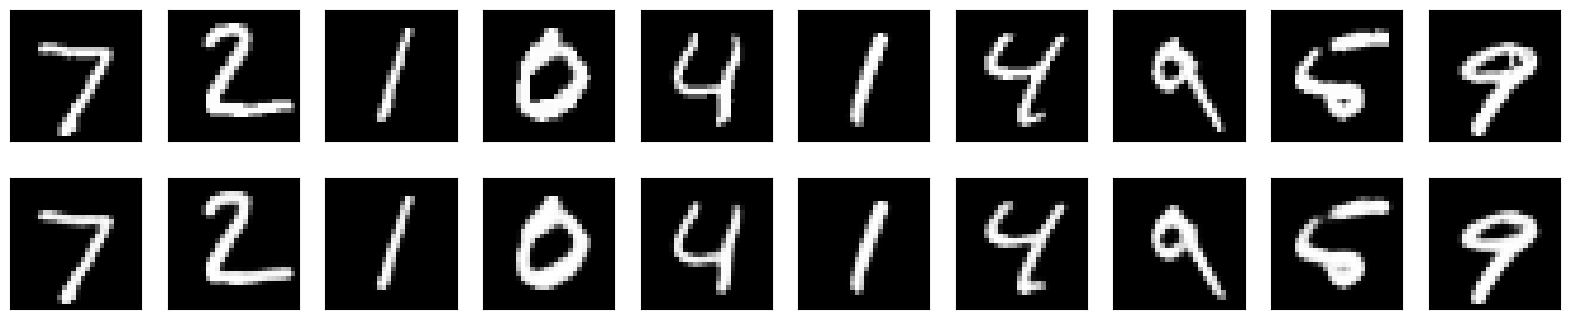

In [21]:
# plot best model decoded images
x_train, x_val, x_test = x_c_train, x_c_val, x_c_test
model = load_model('model_' + 'conv_' + str(study_conv.best_trial.number) + '.keras')
decoded_imgs = model.predict(x_test)
decoded_imgs = np.reshape(decoded_imgs, (len(decoded_imgs), 784))
print_digits(decoded_imgs, x_test)

In [22]:
print(study_conv.best_params)
print(study_conv.best_value)
print(study_conv.best_trial)

{'num_layers': 4, 'filters_0': 61, 'filters_1': 42, 'filters_2': 19, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 9, 'batch_size': 64}
0.06851625442504883
FrozenTrial(number=41, state=TrialState.COMPLETE, values=[0.06851625442504883], datetime_start=datetime.datetime(2023, 12, 24, 15, 37, 49, 768912), datetime_complete=datetime.datetime(2023, 12, 24, 15, 42, 56, 470407), params={'num_layers': 4, 'filters_0': 61, 'filters_1': 42, 'filters_2': 19, 'activation': 'elu', 'optimizer': 'nadam', 'patience': 9, 'batch_size': 64}, user_attrs={'constraint': [254]}, system_attrs={'nsga2:generation': 0, 'constraints': (254,)}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=6, log=False, low=4, step=1), 'filters_0': IntDistribution(high=64, log=False, low=16, step=1), 'filters_1': IntDistribution(high=61, log=False, low=8, step=1), 'filters_2': IntDistribution(high=42, log=False, low=8, step=1), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'gelu'

In [23]:
df_conv = study_conv.trials_dataframe()

df_conv_sorted = df_conv.copy(deep=True)
df_conv_sorted = df_conv_sorted.dropna(subset=['value'])
df_conv_sorted = df_conv_sorted.sort_values(by=['value'], ascending=True)
df_conv_sorted = df_conv_sorted.reset_index(drop=True)
df_conv_sorted

,number,value,datetime_start,datetime_complete,duration,params_activation,params_batch_size,params_filters_0,params_filters_1,params_filters_2,params_filters_3,params_filters_4,params_num_layers,params_optimizer,params_patience,user_attrs_constraint,system_attrs_constraints,system_attrs_nsga2:generation,state
0,41,0.068516,2023-12-24 15:37:49.768912,2023-12-24 15:42:56.470407,0 days 00:05:06.701495,elu,64,61,42,19,NaN,NaN,4,nadam,9,[254],"(254,)",0,COMPLETE
1,3,0.071504,2023-12-24 13:15:59.257677,2023-12-24 13:19:24.943951,0 days 00:03:25.686274,gelu,128,31,25,25,NaN,NaN,4,nadam,9,[350],"(350,)",0,COMPLETE
2,37,0.071623,2023-12-24 15:25:36.481773,2023-12-24 15:32:03.147532,0 days 00:06:26.665759,elu,32,60,18,13,NaN,NaN,4,adam,3,[158],"(158,)",0,COMPLETE
3,1,0.074659,2023-12-24 13:08:09.296076,2023-12-24 13:11:33.592295,0 days 00:03:24.296219,elu,64,42,14,13,NaN,NaN,4,adam,9,[158],"(158,)",0,COMPLETE
4,0,0.077889,2023-12-24 13:05:42.972931,2023-12-24 13:08:09.294631,0 days 00:02:26.321700,relu,512,39,31,23,NaN,NaN,4,adam,4,[318],"(318,)",0,COMPLETE
5,33,0.079014,2023-12-24 15:11:34.563890,2023-12-24 15:14:39.980086,0 days 00:03:05.416196,elu,256,58,45,26,23.0,NaN,5,adam,3,[42],"(42,)",0,COMPLETE
6,19,0.081087,2023-12-24 14:21:06.243583,2023-12-24 14:28:26.911538,0 days 00:07:20.667955,elu,32,59,46,15,8.0,NaN,5,adam,3,[-18],"(-18,)",0,COMPLETE
7,12,0.081956,2023-12-24 13:53:18.915061,2023-12-24 13:56:44.426946,0 days 00:03:25.511885,elu,128,55,40,28,28.0,25.0,6,adam,6,[-25],"(-25,)",0,COMPLETE
8,21,0.085824,2023-12-24 14:31:48.566077,2023-12-24 14:33:01.685429,0 days 00:01:13.119352,relu,512,23,23,15,NaN,NaN,4,adam,4,[190],"(190,)",0,COMPLETE
9,46,0.086270,2023-12-24 15:57:49.846047,2023-12-24 16:01:17.279923,0 days 00:03:27.433876,elu,128,54,52,20,18.0,18.0,6,adam,9,[-32],"(-32,)",0,COMPLETE


In [24]:
plot_optimization_history(study_conv)

In [25]:
plot_slice(study_conv)

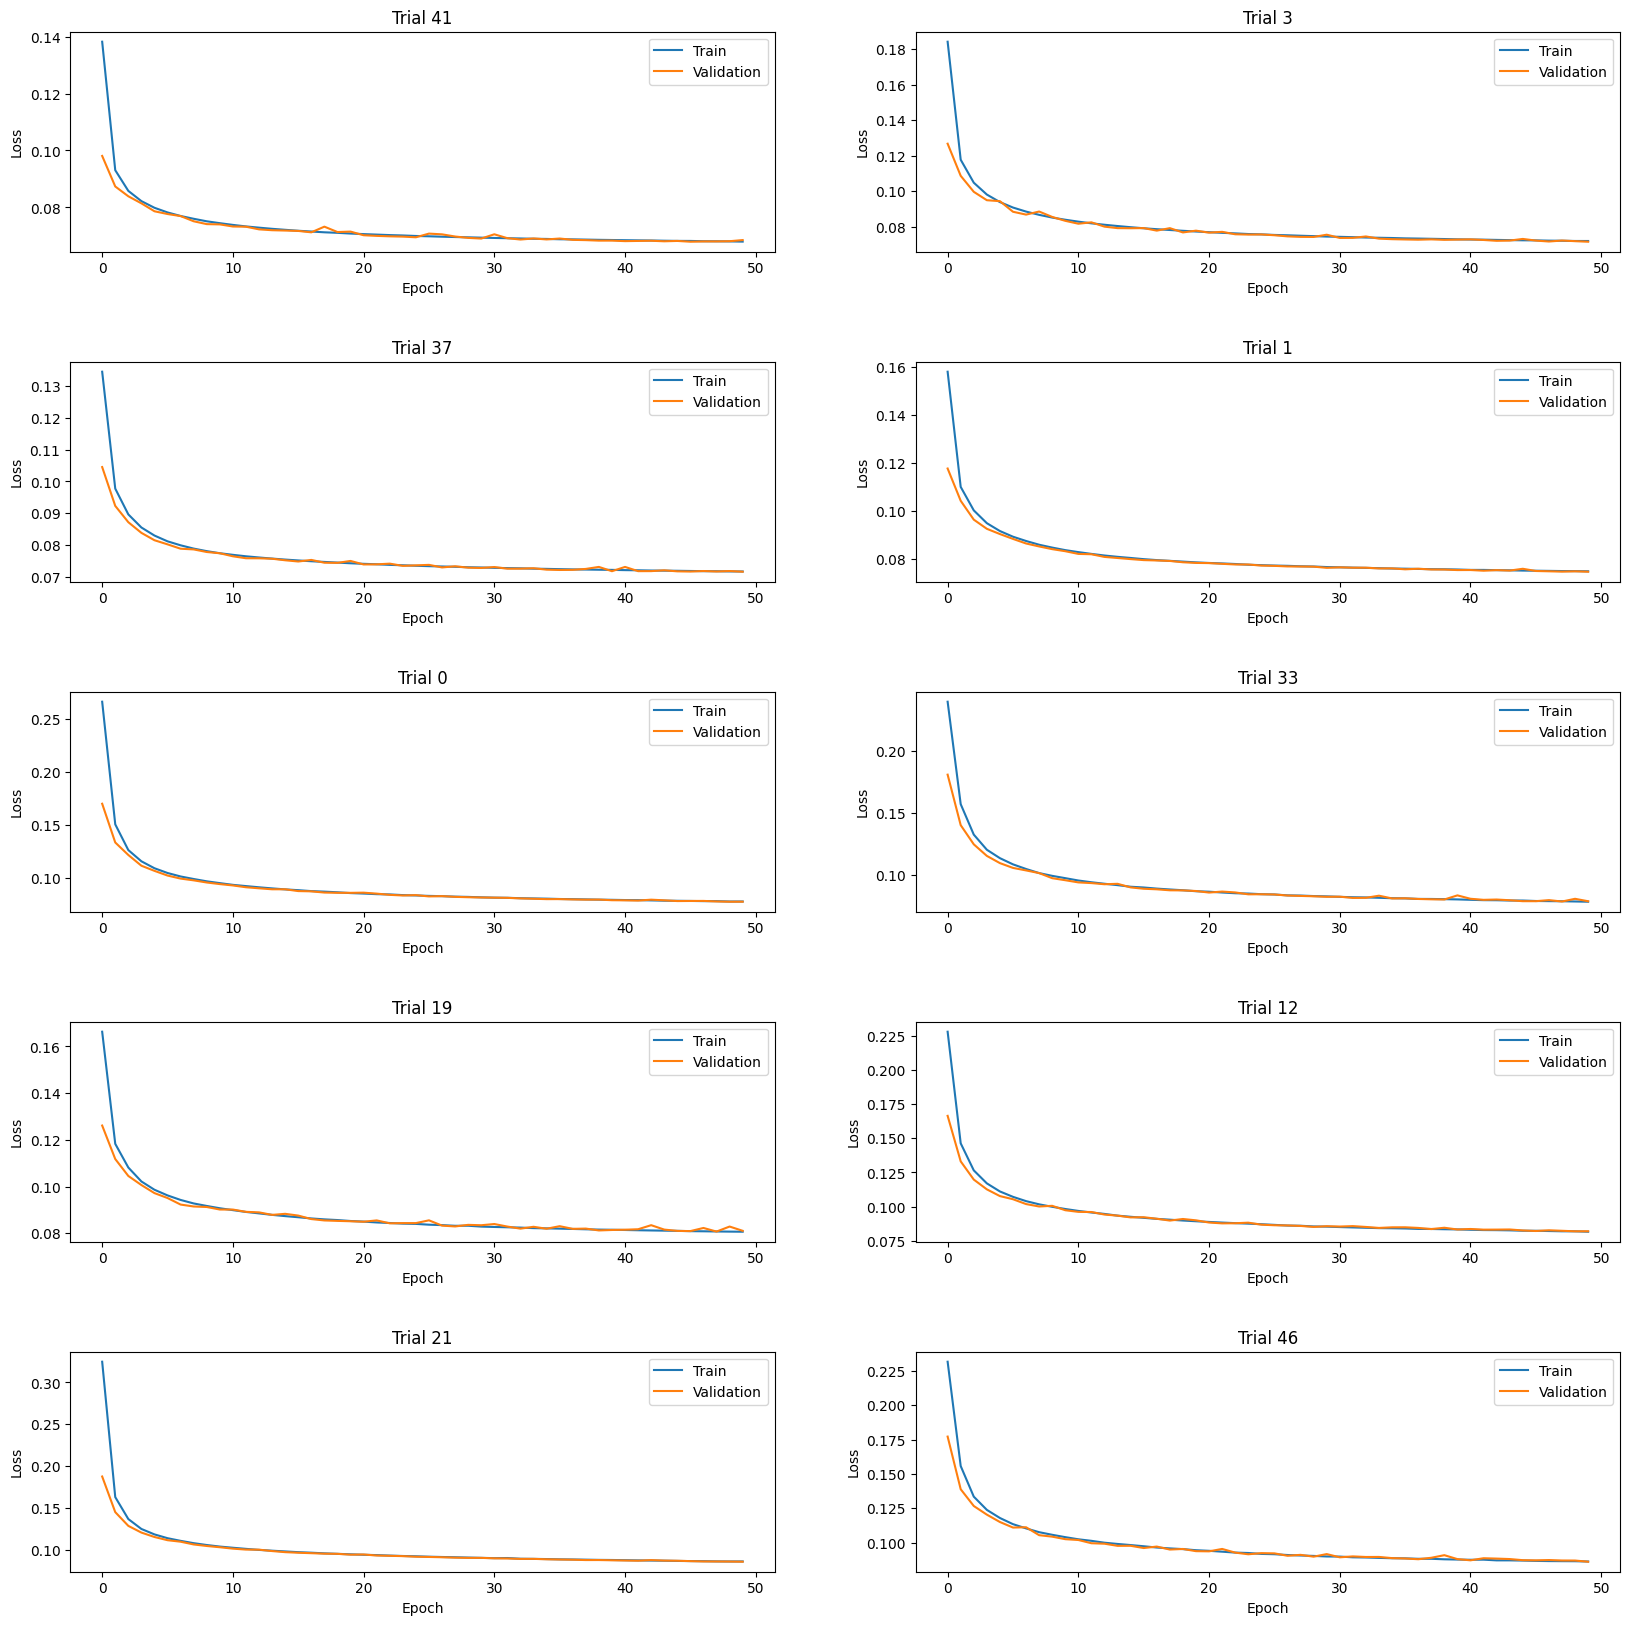

In [26]:
path = '/kaggle/working/'

sorted_trials = sorted([trial for trial in study_conv.trials if trial.value is not None], key=lambda trial: trial.value)
plt.figure(figsize=(20, 20))
for i, trial in enumerate(sorted_trials[:10]):
    history = np.load('history_' + 'conv_' + str(trial.number) + '.npy', allow_pickle=True).item()
    plt.subplot(5, 2, i + 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Trial ' + str(trial.number))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.subplots_adjust(hspace=0.5)
plt.show()